### Libraries

In [1]:
%pip install numba


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
from typing import Tuple, List
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import os
import time
from numba import njit, prange
import itertools

# Preparing the Dataset

In [ ]:
# URL of the dataset
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
zip_file = "ml-32m.zip"
extract_folder = "ml-32m"

print(f"Starting download of {url}...")

# Use !wget to download the file in Colab
# -q makes it quiet (less output)
!wget -q $url

print("Download complete.")

# Check if the file was downloaded successfully
if os.path.exists(zip_file):
    print(f"Successfully downloaded {zip_file}.")

    # Unzip the file
    print(f"Unzipping {zip_file}...")
    # -o overwrites existing files without asking
    # -d specifies the directory to extract to
    !unzip -o $zip_file -d $extract_folder

    print(f"Successfully unzipped to '{extract_folder}' folder.")

    # List the contents of the extracted folder
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: {zip_file} was not downloaded.")

## Setting directory

In [40]:
# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Running in Colab - mount Drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd /content/gdrive/MyDrive/Colab Notebooks/Ml_scale/ml-32m
else:
    # Running locally
    %cd /Users/ethar/Desktop/Master/Masters Blocks/MLscale/ml-32m

/Users/ethar/Desktop/Master/Masters Blocks/MLscale/ml-32m


## Content Verfication

In [41]:
!md5sum links.csv movies.csv ratings.csv tags.csv

8f033867bcb4e6be8792b21468b4fa6e  links.csv
0df90835c19151f9d819d0822e190797  movies.csv
cf12b74f9ad4b94a011f079e26d4270a  ratings.csv
963bf4fa4de6b8901868fddd3eb54567  tags.csv


# Optimization

In [42]:
# NUMBA KERNELS (The Engine Room)
# These functions handle the heavy math logic 
# but compiled to machine code and parallelized.

@njit(parallel=True, fastmath=True)
def _numba_compute_loss(user_ptr, col_indices, values, U, V, b_u, b_m,
                        lamda, gamma_u, gamma_v, gamma_b):
    """
    Numba optimized loss computation.
    """
    squared_error = 0.0
    n_ratings = 0
    n_users = len(user_ptr) - 1

    # Parallel loop over users
    for u in prange(n_users):
        start = user_ptr[u]
        end = user_ptr[u+1]

        if start == end:
            continue

        # Slice for this user
        cols = col_indices[start:end]
        ratings = values[start:end]

        # Calculate error for this user's ratings
        local_error = 0.0
        for i in range(len(cols)):
            m = cols[i]
            r = ratings[i]

            # Dot product U[:, u] @ V[:, m]
            interaction = 0.0
            for f in range(U.shape[0]):
                interaction += U[f, u] * V[f, m]

            pred = interaction + b_u[u] + b_m[m]
            diff = r - pred
            local_error += diff * diff

        squared_error += local_error
        n_ratings += (end - start)

    # Regularization (Global sums)
    user_embedding_reg = np.sum(U ** 2)
    movie_embedding_reg = np.sum(V ** 2)
    user_bias_reg = np.sum(b_u ** 2)
    movie_bias_reg = np.sum(b_m ** 2)

    loss = (lamda / 2) * squared_error + \
           (gamma_u / 2) * user_embedding_reg + \
           (gamma_v / 2) * movie_embedding_reg + \
           (gamma_b / 2) * (user_bias_reg + movie_bias_reg)

    rmse = np.sqrt(squared_error / n_ratings) if n_ratings > 0 else 0.0

    return loss, rmse

@njit(parallel=True, fastmath=True)
def _numba_update_users(user_ptr, col_indices, values, U, V, b_u, b_m,
                        k, lamda, gamma_u, gamma_b):
    """
    Numba optimized User Update loop.
    """
    n_users = len(user_ptr) - 1

    # Iterate over users in parallel
    for u in prange(n_users):
        start = user_ptr[u]
        end = user_ptr[u+1]

        if start == end:
            continue

        n_ratings = end - start
        cols = col_indices[start:end]  # Movie indices
        ratings = values[start:end]    # Rating values

        # 1. BIAS UPDATE
        sum_residuals = 0.0

        for i in range(n_ratings):
            m_idx = cols[i]
            r_val = ratings[i]

            dot_val = 0.0
            for f in range(k):
                dot_val += U[f, u] * V[f, m_idx]

            sum_residuals += (r_val - b_m[m_idx] - dot_val)

        bias = lamda * sum_residuals
        b_u[u] = bias / (lamda * n_ratings + gamma_b)

        # 2. EMBEDDING UPDATE

        # Init A (LHS) with Identity * gamma_u
        A = np.eye(k, dtype=np.float64) * gamma_u
        # Init B (RHS)
        B = np.zeros(k, dtype=np.float64)

        # Accumulate V @ V.T and V @ residuals
        for i in range(n_ratings):
            m_idx = cols[i]
            r_val = ratings[i]

            factor = lamda
            for r in range(k):
                val_r = V[r, m_idx]

                residual = r_val - b_u[u] - b_m[m_idx]
                B[r] += factor * val_r * residual

                for c in range(k):
                    A[r, c] += factor * val_r * V[c, m_idx]

        U[:, u] = np.linalg.solve(A, B)


@njit(parallel=True, fastmath=True)
def _numba_update_movies(movie_ptr, row_indices, values, U, V, b_u, b_m,
                         k, lamda, gamma_v, gamma_b):
    """
    Numba optimized Movie Update loop.
    """
    n_movies = len(movie_ptr) - 1

    for m in prange(n_movies):
        start = movie_ptr[m]
        end = movie_ptr[m+1]

        if start == end:
            continue

        n_ratings = end - start
        rows = row_indices[start:end] # User indices
        ratings = values[start:end]   # Rating values

        # 1. BIAS UPDATE
        sum_residuals = 0.0

        for i in range(n_ratings):
            u_idx = rows[i]
            r_val = ratings[i]

            dot_val = 0.0
            for f in range(k):
                dot_val += U[f, u_idx] * V[f, m]

            sum_residuals += (r_val - b_u[u_idx] - dot_val)

        bias = lamda * sum_residuals
        b_m[m] = bias / (lamda * n_ratings + gamma_b)

        # 2. EMBEDDING UPDATE
        A = np.eye(k, dtype=np.float64) * gamma_v
        B = np.zeros(k, dtype=np.float64)

        factor = lamda
        for i in range(n_ratings):
            u_idx = rows[i]
            r_val = ratings[i]

            # Residual uses updated movie bias
            residual = r_val - b_u[u_idx] - b_m[m]

            for r in range(k):
                val_r = U[r, u_idx]
                B[r] += factor * val_r * residual
                for c in range(k):
                    A[r, c] += factor * val_r * U[c, u_idx]

        V[:, m] = np.linalg.solve(A, B)




In [43]:
# CLASS DEFINITION

class Indexing_Structure:
    """
    Sparse matrix in CSR (Compressed Sparse Row) format for efficient user-based iteration.
    Also maintains CSC (Compressed Sparse Column) format for movie-based iteration.
    """

    def __init__(self, ratings):
        self.number_of_users = 0
        self.userid_to_idx = {}
        self.idx_to_userid = []

        self.number_of_movies = 0
        self.movieid_to_idx = {}
        self.idx_to_movieid = []

        # Temporary storage during construction
        data_by_user = []
        data_by_movie = []

        for rating in ratings:
            # Map user IDs to indices
            if rating[0] not in self.userid_to_idx:
                self.idx_to_userid.append(rating[0])
                self.userid_to_idx[rating[0]] = self.number_of_users
                self.number_of_users += 1
                data_by_user.append([])

            # Map movie IDs to indices
            if rating[1] not in self.movieid_to_idx:
                self.idx_to_movieid.append(rating[1])
                self.movieid_to_idx[rating[1]] = self.number_of_movies
                self.number_of_movies += 1
                data_by_movie.append([])

            user_idx = self.userid_to_idx[rating[0]]
            movie_idx = self.movieid_to_idx[rating[1]]
            rating_val = rating[2].item() if hasattr(rating[2], 'item') else rating[2]

            data_by_user[user_idx].append((movie_idx, rating_val))
            data_by_movie[movie_idx].append((user_idx, rating_val))

        # Build CSR format (for users)
        self._build_csr(data_by_user)

        # Build CSC format (for movies)
        self._build_csc(data_by_movie)

        print(f"Initialized SparseMatrix:")
        print(f"  Users: {self.number_of_users}")
        print(f"  Movies: {self.number_of_movies}")
        print(f"  Ratings: {len(self.csr_col_indices)}")


    def _build_csr(self, data_by_user):
        """Build CSR (Compressed Sparse Row) format for user-based access"""
        self.user_ptr = np.zeros(self.number_of_users + 1, dtype=np.int32)
        all_movie_indices = []
        all_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user):
            all_movie_indices.extend([movie_idx for movie_idx, rating in user_ratings])
            all_ratings.extend([rating for movie_idx, rating in user_ratings])
            self.user_ptr[user_idx + 1] = len(all_movie_indices)

        self.csr_col_indices = np.array(all_movie_indices, dtype=np.int32)
        self.csr_values = np.array(all_ratings, dtype=np.float32)


    def _build_csc(self, data_by_movie):
        """Build CSC (Compressed Sparse Column) format for movie-based access"""
        self.movie_ptr = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        all_user_indices = []
        all_ratings = []

        for movie_idx, movie_ratings in enumerate(data_by_movie):
            all_user_indices.extend([user_idx for user_idx, rating in movie_ratings])
            all_ratings.extend([rating for user_idx, rating in movie_ratings])
            self.movie_ptr[movie_idx + 1] = len(all_user_indices)

        self.csc_row_indices = np.array(all_user_indices, dtype=np.int32)
        self.csc_values = np.array(all_ratings, dtype=np.float32)


    def split(self, split_ratio):
        """
        Split data into train/test sets.
        Randomly assigns each rating to train or test, then rebuilds CSR/CSC structures.
        """
        n_ratings = len(self.csr_values)

        # Random train/test assignment
        random_vals = np.random.random(n_ratings)
        train_mask = random_vals < split_ratio
        test_mask = ~train_mask

        # Split CSR data
        data_by_user_train = [[] for _ in range(self.number_of_users)]
        data_by_user_test = [[] for _ in range(self.number_of_users)]

        for user_idx in range(self.number_of_users):
            start = self.user_ptr[user_idx]
            end = self.user_ptr[user_idx + 1]

            for i in range(start, end):
                movie_idx = self.csr_col_indices[i]
                rating = self.csr_values[i]

                if train_mask[i]:
                    data_by_user_train[user_idx].append((movie_idx, rating))
                else:
                    data_by_user_test[user_idx].append((movie_idx, rating))

        # Build train CSR
        self.user_ptr_train = np.zeros(self.number_of_users + 1, dtype=np.int32)
        train_movies = []
        train_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user_train):
            train_movies.extend([m for m, r in user_ratings])
            train_ratings.extend([r for m, r in user_ratings])
            self.user_ptr_train[user_idx + 1] = len(train_movies)

        self.csr_col_indices_train = np.array(train_movies, dtype=np.int32)
        self.csr_values_train = np.array(train_ratings, dtype=np.float32)

        # Build test CSR
        self.user_ptr_test = np.zeros(self.number_of_users + 1, dtype=np.int32)
        test_movies = []
        test_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user_test):
            test_movies.extend([m for m, r in user_ratings])
            test_ratings.extend([r for m, r in user_ratings])
            self.user_ptr_test[user_idx + 1] = len(test_movies)

        self.csr_col_indices_test = np.array(test_movies, dtype=np.int32)
        self.csr_values_test = np.array(test_ratings, dtype=np.float32)

        # Build train/test CSC (for movie iterations)
        data_by_movie_train = [[] for _ in range(self.number_of_movies)]
        data_by_movie_test = [[] for _ in range(self.number_of_movies)]

        for user_idx in range(self.number_of_users):
            for movie_idx, rating in data_by_user_train[user_idx]:
                data_by_movie_train[movie_idx].append((user_idx, rating))
            for movie_idx, rating in data_by_user_test[user_idx]:
                data_by_movie_test[movie_idx].append((user_idx, rating))

        # Build train CSC
        self.movie_ptr_train = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        train_users = []
        train_ratings_csc = []

        for movie_idx, movie_ratings in enumerate(data_by_movie_train):
            train_users.extend([u for u, r in movie_ratings])
            train_ratings_csc.extend([r for u, r in movie_ratings])
            self.movie_ptr_train[movie_idx + 1] = len(train_users)

        self.csc_row_indices_train = np.array(train_users, dtype=np.int32)
        self.csc_values_train = np.array(train_ratings_csc, dtype=np.float32)

        # Build test CSC
        self.movie_ptr_test = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        test_users = []
        test_ratings_csc = []

        for movie_idx, movie_ratings in enumerate(data_by_movie_test):
            test_users.extend([u for u, r in movie_ratings])
            test_ratings_csc.extend([r for u, r in movie_ratings])
            self.movie_ptr_test[movie_idx + 1] = len(test_users)

        self.csc_row_indices_test = np.array(test_users, dtype=np.int32)
        self.csc_values_test = np.array(test_ratings_csc, dtype=np.float32)

        # Store counts
        self.number_of_users_train = self.number_of_users
        self.number_of_movies_train = self.number_of_movies
        self.number_of_users_test = self.number_of_users
        self.number_of_movies_test = self.number_of_movies

        n_train = len(self.csr_values_train)
        n_test = len(self.csr_values_test)

        print(f"\nData split:")
        print(f"  Train ratings: {n_train} ({n_train/(n_train+n_test)*100:.2f}%)")
        print(f"  Test ratings: {n_test} ({n_test/(n_train+n_test)*100:.2f}%)")






def plot_training_results(loss_history, rmse_history, rmse_test_history):
    """Plot training metrics"""
    plt.figure(figsize=(18, 5))

    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(loss_history, marker='o')
    plt.title("Loss over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)

    # Plot training RMSE
    plt.subplot(1, 3, 2)
    plt.plot(rmse_history, marker='o', color='orange')
    plt.title("Training RMSE")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)

    # Plot test RMSE
    plt.subplot(1, 3, 3)
    plt.plot(rmse_test_history, marker='o', color='green')
    plt.title("Test RMSE")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



In [44]:
# LOAD DATA

# Using 'float' explicitly ensures compatibility
ratings = np.loadtxt("ratings.csv", delimiter=",", skiprows=1, usecols=(0, 1, 2))

# Create sparse matrix
ratings_matrix = Indexing_Structure(ratings)

# Split data
ratings_matrix.split(0.9)
print("Data loaded and split successfully!")


Initialized SparseMatrix:
  Users: 200948
  Movies: 84432
  Ratings: 32000204

Data split:
  Train ratings: 28798702 (90.00%)
  Test ratings: 3201502 (10.00%)
Data loaded and split successfully!



In [9]:
# NUMBA KERNELS 

@njit(parallel=True)
def compute_rmse_numba(user_ptr, csr_col_indices, csr_values,
                       user_embeddings, movie_embeddings,
                       user_biases, movie_biases):
    """Compute RMSE using CSR format with parallel processing."""
    n_users = len(user_ptr) - 1
    squared_errors = np.zeros(n_users)
    counts = np.zeros(n_users, dtype=np.int32)

    for user_idx in prange(n_users):
        start = user_ptr[user_idx]
        end = user_ptr[user_idx + 1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        local_se = 0.0
        user_emb = user_embeddings[:, user_idx].copy()

        for i in range(start, end):
            movie_idx = csr_col_indices[i]
            rating = csr_values[i]
            movie_emb = movie_embeddings[:, movie_idx].copy()

            pred = user_biases[user_idx] + movie_biases[movie_idx] + np.dot(user_emb, movie_emb)
            local_se += (rating - pred) ** 2

        squared_errors[user_idx] = local_se
        counts[user_idx] = n_ratings

    total_se = np.sum(squared_errors)
    total_count = np.sum(counts)

    return np.sqrt(total_se / total_count) if total_count > 0 else np.inf


@njit
def solve_linear_system(A, b):
    """Solve Ax = b with numerical stability."""
    k = len(b)
    A_stable = A + 1e-10 * np.eye(k)

    if not np.all(np.isfinite(A_stable)) or not np.all(np.isfinite(b)):
        return np.zeros(k)

    try:
        L = np.linalg.cholesky(A_stable)
        y = np.linalg.solve(L, b)
        x = np.linalg.solve(L.T, y)
        if np.all(np.isfinite(x)):
            return x
    except:
        pass

    x, _, _, _ = np.linalg.lstsq(A_stable, b)
    if not np.all(np.isfinite(x)):
        return np.zeros(k)

    return x


@njit
def update_user_params(user_idx, user_ptr, csr_col_indices, csr_values,
                       user_embeddings, movie_embeddings, movie_biases,
                       lamda, gamma_u, gamma_b, k):
    """Update user bias and embedding."""
    start = user_ptr[user_idx]
    end = user_ptr[user_idx + 1]
    n_ratings = end - start

    if n_ratings == 0:
        return 0.0, user_embeddings[:, user_idx].copy()

    # Update bias
    bias_sum = 0.0
    user_emb = user_embeddings[:, user_idx].copy()
    
    for i in range(start, end):
        movie_idx = csr_col_indices[i]
        rating = csr_values[i]
        movie_emb = movie_embeddings[:, movie_idx].copy()
        pred_no_bias = np.dot(user_emb, movie_emb)
        bias_sum += rating - movie_biases[movie_idx] - pred_no_bias

    new_bias = (lamda * bias_sum) / (lamda * n_ratings + gamma_b)

    # Update embedding
    first_term = gamma_u * np.eye(k)
    second_term = np.zeros(k)

    for i in range(start, end):
        movie_idx = csr_col_indices[i]
        rating = csr_values[i]
        v_n = movie_embeddings[:, movie_idx].copy()
        
        if not np.all(np.isfinite(v_n)):
            continue

        first_term += lamda * np.outer(v_n, v_n)
        resid = rating - new_bias - movie_biases[movie_idx]
        second_term += lamda * v_n * resid

    new_emb = solve_linear_system(first_term, second_term)
    return new_bias, new_emb


@njit
def update_movie_params(movie_idx, movie_ptr, csc_row_indices, csc_values,
                        user_embeddings, movie_embeddings, user_biases,
                        lamda, gamma_v, gamma_b, k):
    """Update movie bias and embedding."""
    start = movie_ptr[movie_idx]
    end = movie_ptr[movie_idx + 1]
    m_ratings = end - start

    if m_ratings == 0:
        return 0.0, movie_embeddings[:, movie_idx].copy()

    # Update bias
    bias_sum = 0.0
    movie_emb = movie_embeddings[:, movie_idx].copy()
    
    for i in range(start, end):
        user_idx = csc_row_indices[i]
        rating = csc_values[i]
        user_emb = user_embeddings[:, user_idx].copy()
        pred_no_bias = np.dot(user_emb, movie_emb)
        bias_sum += rating - user_biases[user_idx] - pred_no_bias

    new_bias = (lamda * bias_sum) / (lamda * m_ratings + gamma_b)

    # Update embedding
    first_term = gamma_v * np.eye(k)
    second_term = np.zeros(k)

    for i in range(start, end):
        user_idx = csc_row_indices[i]
        rating = csc_values[i]
        u_m = user_embeddings[:, user_idx].copy()
        
        if not np.all(np.isfinite(u_m)):
            continue

        first_term += lamda * np.outer(u_m, u_m)
        resid = rating - user_biases[user_idx] - new_bias
        second_term += lamda * u_m * resid

    new_emb = solve_linear_system(first_term, second_term)
    return new_bias, new_emb


@njit
def train_one_iteration(user_ptr, csr_col_indices, csr_values,
                        movie_ptr, csc_row_indices, csc_values,
                        user_embeddings, movie_embeddings,
                        user_biases, movie_biases,
                        lamda, gamma_u, gamma_v, gamma_b, k):
    """One full ALS iteration."""
    n_users = len(user_ptr) - 1
    n_movies = len(movie_ptr) - 1

    # Update users
    for user_idx in range(n_users):
        new_bias, new_emb = update_user_params(
            user_idx, user_ptr, csr_col_indices, csr_values,
            user_embeddings, movie_embeddings, movie_biases,
            lamda, gamma_u, gamma_b, k
        )
        user_biases[user_idx] = new_bias
        user_embeddings[:, user_idx] = new_emb

    # Update movies
    for movie_idx in range(n_movies):
        new_bias, new_emb = update_movie_params(
            movie_idx, movie_ptr, csc_row_indices, csc_values,
            user_embeddings, movie_embeddings, user_biases,
            lamda, gamma_v, gamma_b, k
        )
        movie_biases[movie_idx] = new_bias
        movie_embeddings[:, movie_idx] = new_emb

    return user_embeddings, movie_embeddings, user_biases, movie_biases


@njit
def train_with_early_stopping(user_ptr_train, csr_col_train, csr_val_train,
                               movie_ptr_train, csc_row_train, csc_val_train,
                               user_ptr_test, csr_col_test, csr_val_test,
                               user_embeddings, movie_embeddings,
                               user_biases, movie_biases,
                               lamda, gamma_u, gamma_v, gamma_b, k,
                               max_iterations, patience):
    """
    Train with early stopping based on test RMSE.
    Stops if test RMSE doesn't improve for 'patience' iterations.
    """
    best_test_rmse = np.inf
    no_improve_count = 0
    
    for iteration in range(max_iterations):
        # Train one iteration
        user_embeddings, movie_embeddings, user_biases, movie_biases = train_one_iteration(
            user_ptr_train, csr_col_train, csr_val_train,
            movie_ptr_train, csc_row_train, csc_val_train,
            user_embeddings, movie_embeddings,
            user_biases, movie_biases,
            lamda, gamma_u, gamma_v, gamma_b, k
        )
        
        # Evaluate on test set
        test_rmse = compute_rmse_numba(
            user_ptr_test, csr_col_test, csr_val_test,
            user_embeddings, movie_embeddings, user_biases, movie_biases
        )
        
        # Early stopping check
        if test_rmse < best_test_rmse - 1e-5:  # Improvement threshold
            best_test_rmse = test_rmse
            no_improve_count = 0
        else:
            no_improve_count += 1
            
        if no_improve_count >= patience:
            break
    
    return user_embeddings, movie_embeddings, user_biases, movie_biases, best_test_rmse


# RANDOM SEARCH WITH EARLY STOPPING

def random_search(ratings_matrix, param_distributions, n_trials=50, 
                  max_iterations=20, patience=3, verbose=True):
    """
    Random search with early stopping - Much faster than grid search!
    
    Parameters:
    -----------
    param_distributions : dict
        Dictionary with parameter names and (min, max) tuples or lists of values
    n_trials : int
        Number of random combinations to try
    max_iterations : int
        Maximum iterations per trial
    patience : int
        Early stopping patience
    """
    
    results = []
    best_rmse = float('inf')
    best_params = None
    best_embeddings = None
    
    if verbose:
        print(f"Random Search: {n_trials} trials with early stopping (patience={patience})")
        print("-" * 100)
        print(f"{'#':<4} {'k':<4} {'lamda':<10} {'γu':<10} {'γv':<10} {'γb':<10} | {'Test RMSE':<10} {'Iters':<6} {'Time(s)':<8}")
        print("-" * 100)
    
    # Prepare arrays once
    user_ptr_train = np.ascontiguousarray(ratings_matrix.user_ptr_train, dtype=np.int32)
    csr_col_train = np.ascontiguousarray(ratings_matrix.csr_col_indices_train, dtype=np.int32)
    csr_val_train = np.ascontiguousarray(ratings_matrix.csr_values_train, dtype=np.float64)
    
    movie_ptr_train = np.ascontiguousarray(ratings_matrix.movie_ptr_train, dtype=np.int32)
    csc_row_train = np.ascontiguousarray(ratings_matrix.csc_row_indices_train, dtype=np.int32)
    csc_val_train = np.ascontiguousarray(ratings_matrix.csc_values_train, dtype=np.float64)
    
    user_ptr_test = np.ascontiguousarray(ratings_matrix.user_ptr_test, dtype=np.int32)
    csr_col_test = np.ascontiguousarray(ratings_matrix.csr_col_indices_test, dtype=np.int32)
    csr_val_test = np.ascontiguousarray(ratings_matrix.csr_values_test, dtype=np.float64)
    
    for trial in range(n_trials):
        start_time = time.time()
        
        # Sample random parameters
        if isinstance(param_distributions['k'], list):
            k = np.random.choice(param_distributions['k'])
        else:
            k = np.random.randint(param_distributions['k'][0], param_distributions['k'][1] + 1)
        
        lamda = 10 ** np.random.uniform(np.log10(param_distributions['lamda'][0]), 
                                         np.log10(param_distributions['lamda'][1]))
        gamma_u = 10 ** np.random.uniform(np.log10(param_distributions['gamma_u'][0]), 
                                           np.log10(param_distributions['gamma_u'][1]))
        gamma_v = 10 ** np.random.uniform(np.log10(param_distributions['gamma_v'][0]), 
                                           np.log10(param_distributions['gamma_v'][1]))
        gamma_b = 10 ** np.random.uniform(np.log10(param_distributions['gamma_b'][0]), 
                                           np.log10(param_distributions['gamma_b'][1]))
        
        # Initialize
        user_biases = np.zeros(ratings_matrix.number_of_users, dtype=np.float64)
        movie_biases = np.zeros(ratings_matrix.number_of_movies, dtype=np.float64)
        user_embeddings = np.ascontiguousarray(
            np.random.normal(0, 0.01, size=(k, ratings_matrix.number_of_users)),
            dtype=np.float64
        )
        movie_embeddings = np.ascontiguousarray(
            np.random.normal(0, 0.01, size=(k, ratings_matrix.number_of_movies)),
            dtype=np.float64
        )
        
        # Train with early stopping
        user_embeddings, movie_embeddings, user_biases, movie_biases, test_rmse = \
            train_with_early_stopping(
                user_ptr_train, csr_col_train, csr_val_train,
                movie_ptr_train, csc_row_train, csc_val_train,
                user_ptr_test, csr_col_test, csr_val_test,
                user_embeddings, movie_embeddings,
                user_biases, movie_biases,
                lamda, gamma_u, gamma_v, gamma_b, k,
                max_iterations, patience
            )
        
        elapsed = time.time() - start_time
        actual_iters = min(max_iterations, patience + 1)  # Approximate
        
        if verbose:
            print(f"{trial+1:<4} {k:<4} {lamda:<10.6f} {gamma_u:<10.6f} {gamma_v:<10.6f} {gamma_b:<10.6f} | "
                  f"{test_rmse:<10.5f} {actual_iters:<6} {elapsed:<8.1f}")
        
        results.append({
            'k': k, 'lamda': lamda, 'gamma_u': gamma_u,
            'gamma_v': gamma_v, 'gamma_b': gamma_b,
            'test_rmse': test_rmse, 'time_seconds': elapsed
        })
        
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_params = {
                'k': k, 'lamda': lamda, 'gamma_u': gamma_u,
                'gamma_v': gamma_v, 'gamma_b': gamma_b
            }
            best_embeddings = {
                'user_embeddings': user_embeddings.copy(),
                'movie_embeddings': movie_embeddings.copy(),
                'user_biases': user_biases.copy(),
                'movie_biases': movie_biases.copy()
            }
    
    if verbose:
        print("-" * 100)
        print(f"Best Test RMSE: {best_rmse:.6f}")
        print(f"Best Parameters: {best_params}")
    
    return pd.DataFrame(results), best_params, best_embeddings


# EXECUTE
print("Starting Random Search with Early Stopping...")
param_distributions = {
    'k': [10, 20, 30],  # Discrete choices
    'lamda': (0.001, 1.0),  # Log-uniform between these values
    'gamma_u': (0.001, 1.0),
    'gamma_v': (0.001, 1.0),
    'gamma_b': (0.001, 1.0)
}

results_df, best_params, best_embeddings = random_search(
    ratings_matrix,
    param_distributions,
    n_trials=50,  # Try 50 random combinations
    max_iterations=15,
    patience=3,
    verbose=True
)


# Save and display results
print("\n" + "="*100)
print("TOP 10 RESULTS")
print("="*100)
print(results_df.sort_values('test_rmse').head(10))

results_df.to_csv('random_search_results.csv', index=False)
print("\n✓ Results saved to 'random_search_results.csv'")

Starting Random Search with Early Stopping...
Random Search: 50 trials with early stopping (patience=3)
----------------------------------------------------------------------------------------------------
#    k    lamda      γu         γv         γb         | Test RMSE  Iters  Time(s) 
----------------------------------------------------------------------------------------------------
1    10   0.920376   0.004451   0.026428   0.320946   | 0.83692    4      271.3   
2    10   0.053563   0.364916   0.008717   0.175875   | 0.78926    4      266.1   
3    10   0.336835   0.853103   0.372943   0.814620   | 0.78463    4      262.2   
4    10   0.053541   0.003891   0.102720   0.199874   | 0.79107    4      264.9   
5    10   0.003949   0.432868   0.008508   0.001273   | 0.77445    4      263.7   
6    20   0.004100   0.305646   0.097840   0.602145   | 0.82299    4      390.8   
7    10   0.415118   0.164800   0.007204   0.003335   | 0.79324    4      259.9   
8    30   0.124259   0.013814 

✓ Saved: rmse_by_k.pdf


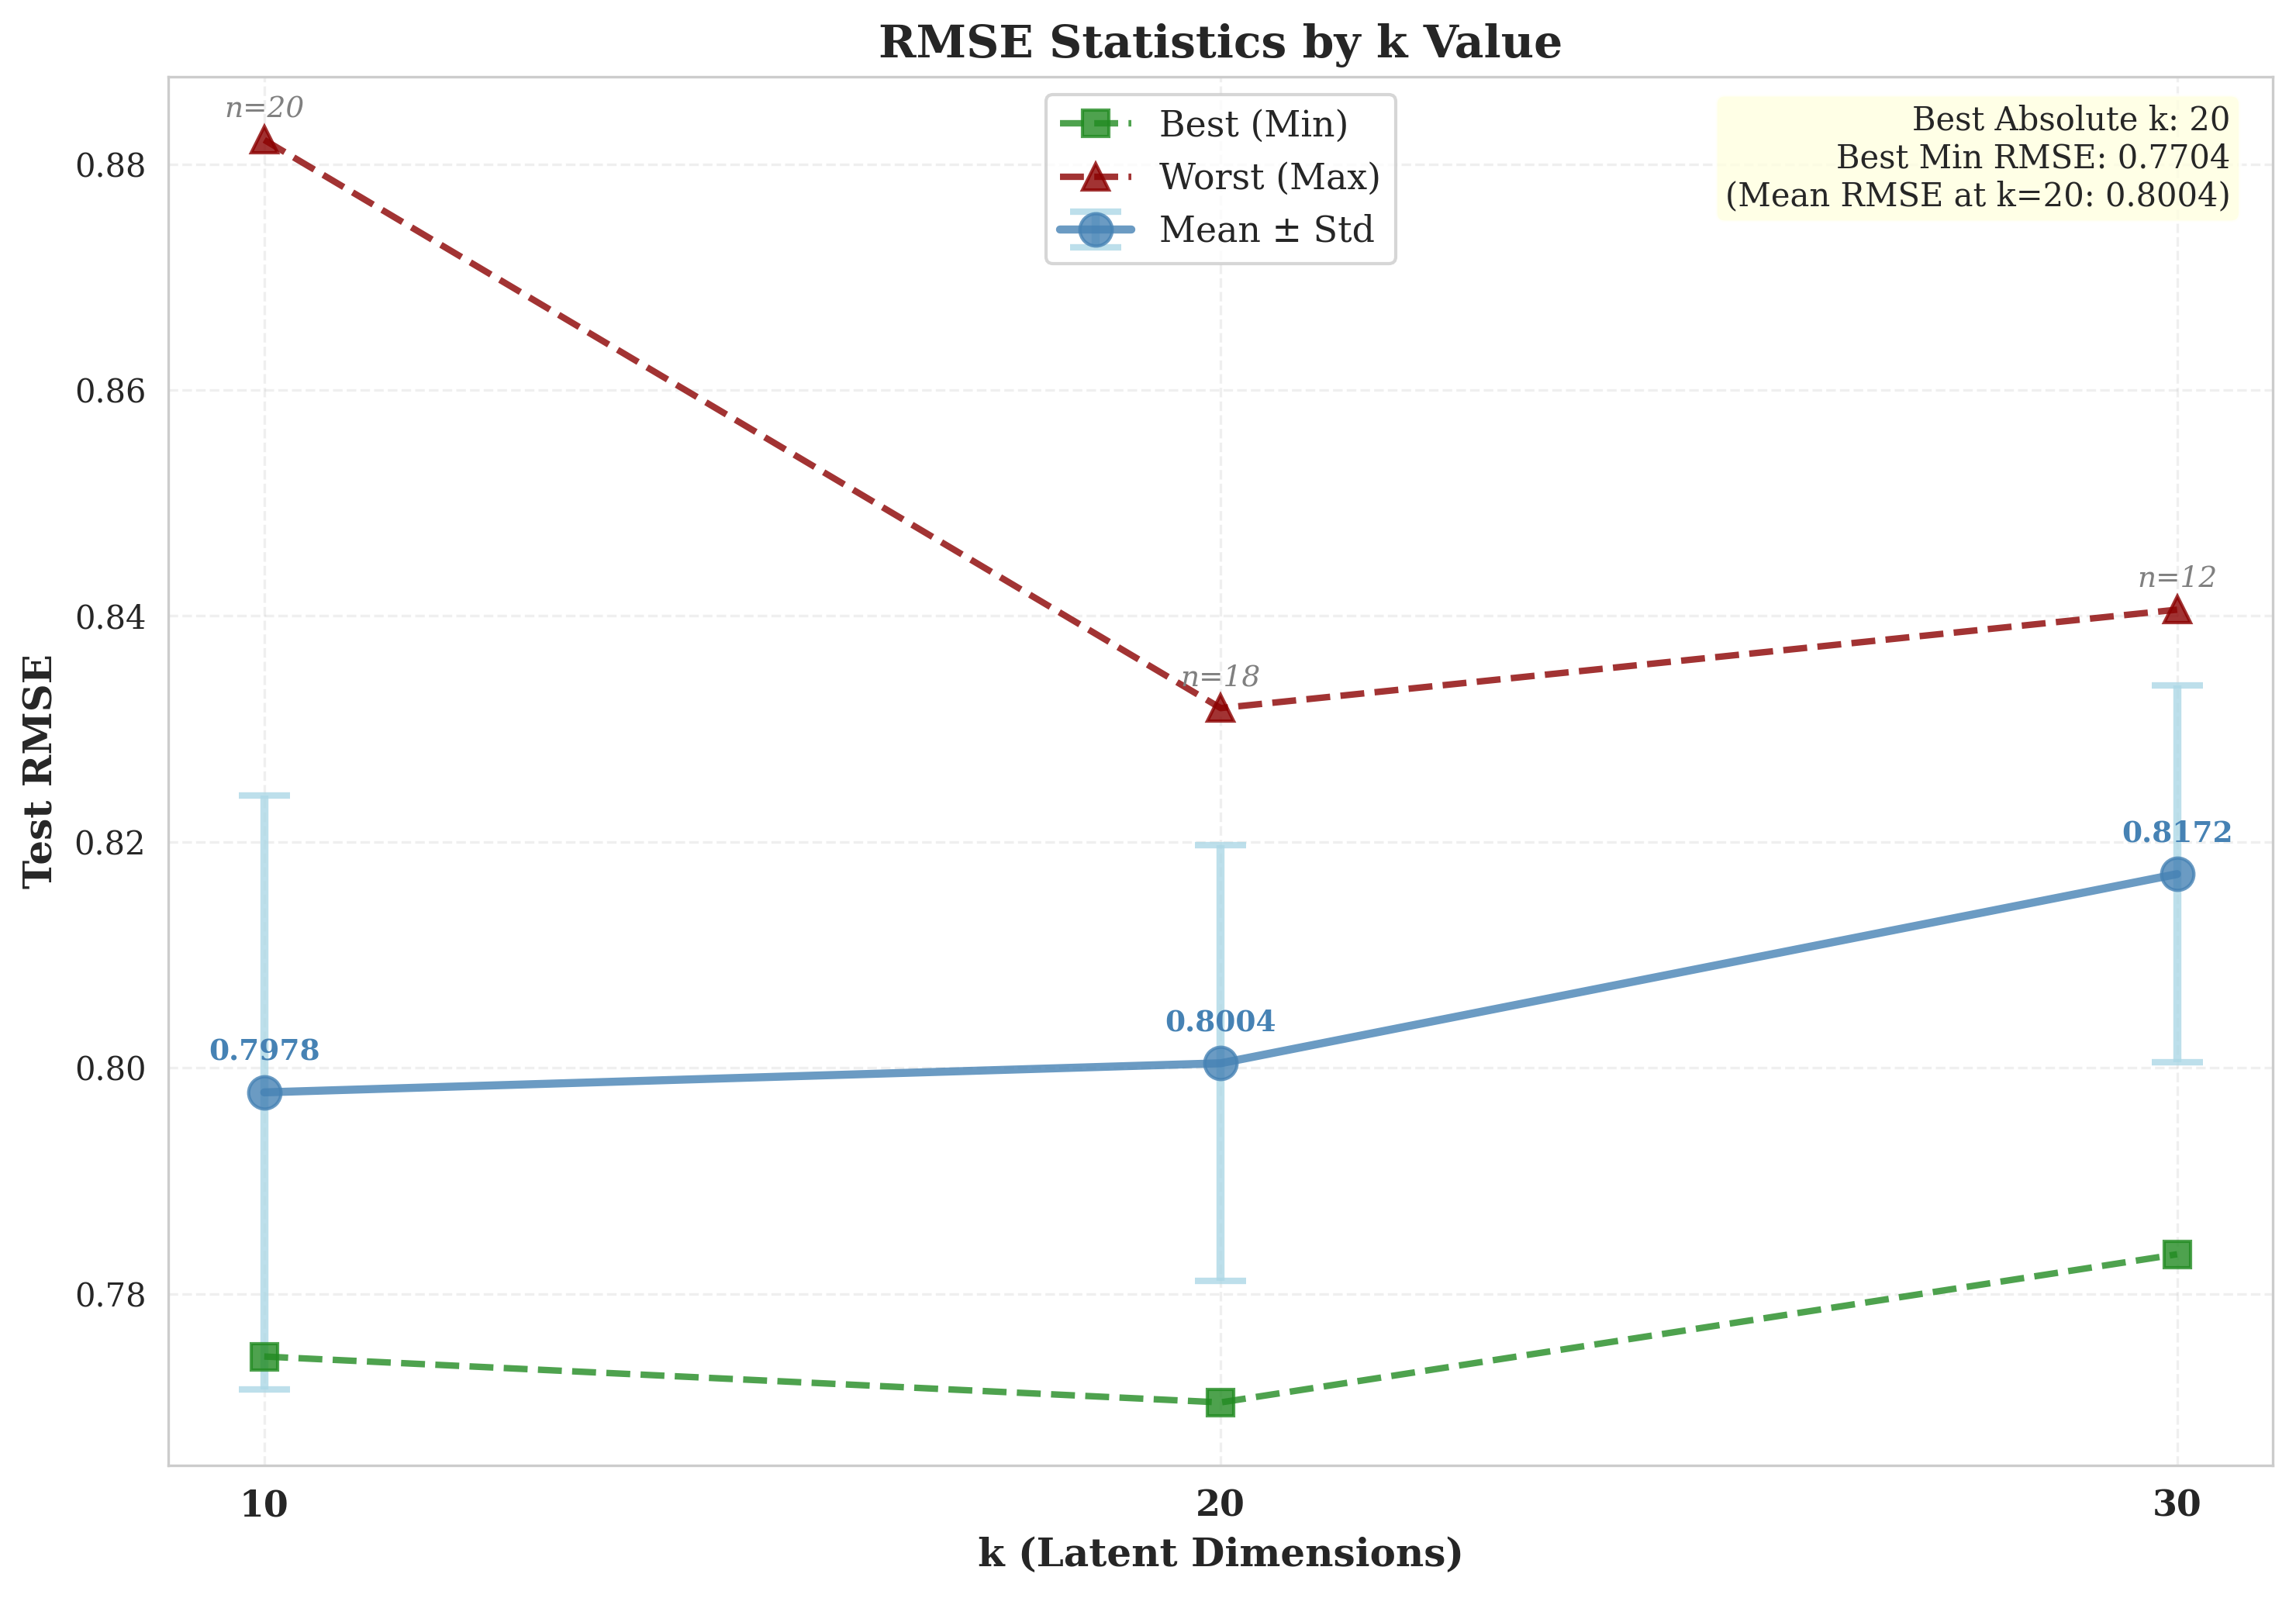


RMSE STATISTICS BY k

k      Mean       Std        Min        Max        Count   
----------------------------------------------------------------------
10     0.797832   0.026305   0.774453   0.882136   20      
20     0.800409   0.019283   0.770391   0.831845   18      
30     0.817154   0.016683   0.783502   0.840556   12      
----------------------------------------------------------------------
Best k (by mean RMSE): 10 (RMSE: 0.797832)
Most stable k (by std): 30 (Std: 0.016683)


SUMMARY STATISTICS

Best RMSE: 0.770391
Worst RMSE: 0.882136
Mean RMSE: 0.803397
Std RMSE: 0.022849

Best Configuration:
  k: 20.000000
  lamda: 0.020393
  gamma_u: 0.858755
  gamma_v: 0.803412
  gamma_b: 0.001924

Total trials: 50
Average time per trial: 452.32s
Total search time: 22615.78s



In [52]:
# # Load results
results_df = pd.read_csv('random_search_results.csv')

# RMSE STATISTICS BY k (FIXED)

plt.figure(figsize=(10, 7))

# Calculate statistics by k

k_stats = results_df.groupby('k')['test_rmse'].agg(['mean', 'std', 'min', 'max', 'count']).sort_index()
x = range(len(k_stats))

# Plot mean with error bars
plt.errorbar(x, k_stats['mean'], yerr=k_stats['std'], fmt='o-', 
             capsize=8, capthick=2, markersize=10, linewidth=2.5,
             color='steelblue', ecolor='lightblue', label='Mean ± Std',
             alpha=0.8)

# Plot min values (The "Best" individual runs)
plt.plot(x, k_stats['min'], 's--', linewidth=2, markersize=8,
         color='forestgreen', label='Best (Min)', alpha=0.8)

# Plot max values
plt.plot(x, k_stats['max'], '^--', linewidth=2, markersize=8,
         color='darkred', label='Worst (Max)', alpha=0.8)

# Annotations for each k
for i, k_val in enumerate(k_stats.index):
    # Annotate mean
    plt.annotate(f'{k_stats["mean"].iloc[i]:.4f}', 
                xy=(i, k_stats['mean'].iloc[i]), 
                xytext=(0, 10), textcoords='offset points',
                fontsize=9, ha='center', color='steelblue', fontweight='bold')
    
    # Annotate count
    plt.text(i, k_stats['max'].iloc[i] + 0.002, 
             f'n={int(k_stats["count"].iloc[i])}',
             ha='center', fontsize=9, color='gray', style='italic')

plt.xticks(x, k_stats.index, fontsize=11, fontweight='bold')
plt.xlabel('k (Latent Dimensions)', fontsize=12, fontweight='bold')
plt.ylabel('Test RMSE', fontsize=12, fontweight='bold')
plt.title('RMSE Statistics by k Value', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')

best_k = k_stats['min'].idxmin()       # Finds k with the lowest minimum value
best_val = k_stats['min'].min()        # The actual RMSE value
best_k_mean = k_stats.loc[best_k, 'mean'] # The mean for that k

stats_text = f'Best Absolute k: {best_k}\n'
stats_text += f'Best Min RMSE: {best_val:.4f}\n'
stats_text += f'(Mean RMSE at k={best_k}: {best_k_mean:.4f})'

plt.text(0.98, 0.98, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', ha='right',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('rmse_by_k.pdf', format='pdf', dpi=300, bbox_inches='tight')
print("✓ Saved: rmse_by_k.pdf")
plt.show()
plt.close()

print("\n" + "="*70)
print("RMSE STATISTICS BY k")
print("="*70)
print(f"\n{'k':<6} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Count':<8}")
print("-"*70)
for k_val, row in k_stats.iterrows():
    print(f"{k_val:<6} {row['mean']:<10.6f} {row['std']:<10.6f} "
          f"{row['min']:<10.6f} {row['max']:<10.6f} {int(row['count']):<8}")
print("-"*70)
print(f"Best k (by mean RMSE): {k_stats['mean'].idxmin()} "
      f"(RMSE: {k_stats['mean'].min():.6f})")
print(f"Most stable k (by std): {k_stats['std'].idxmin()} "
      f"(Std: {k_stats['std'].min():.6f})")
print("="*70 + "\n")

# SUMMARY STATISTICS

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nBest RMSE: {results_df['test_rmse'].min():.6f}")
print(f"Worst RMSE: {results_df['test_rmse'].max():.6f}")
print(f"Mean RMSE: {results_df['test_rmse'].mean():.6f}")
print(f"Std RMSE: {results_df['test_rmse'].std():.6f}")

print("\nBest Configuration:")
best_idx = results_df['test_rmse'].idxmin()
best_config = results_df.loc[best_idx]
for param in ['k', 'lamda', 'gamma_u', 'gamma_v', 'gamma_b']:
    print(f"  {param}: {best_config[param]:.6f}")

print(f"\nTotal trials: {len(results_df)}")
print(f"Average time per trial: {results_df['time_seconds'].mean():.2f}s")
print(f"Total search time: {results_df['time_seconds'].sum():.2f}s")

print("\n" + "="*80)

Saved: fig_convergence.pdf/png


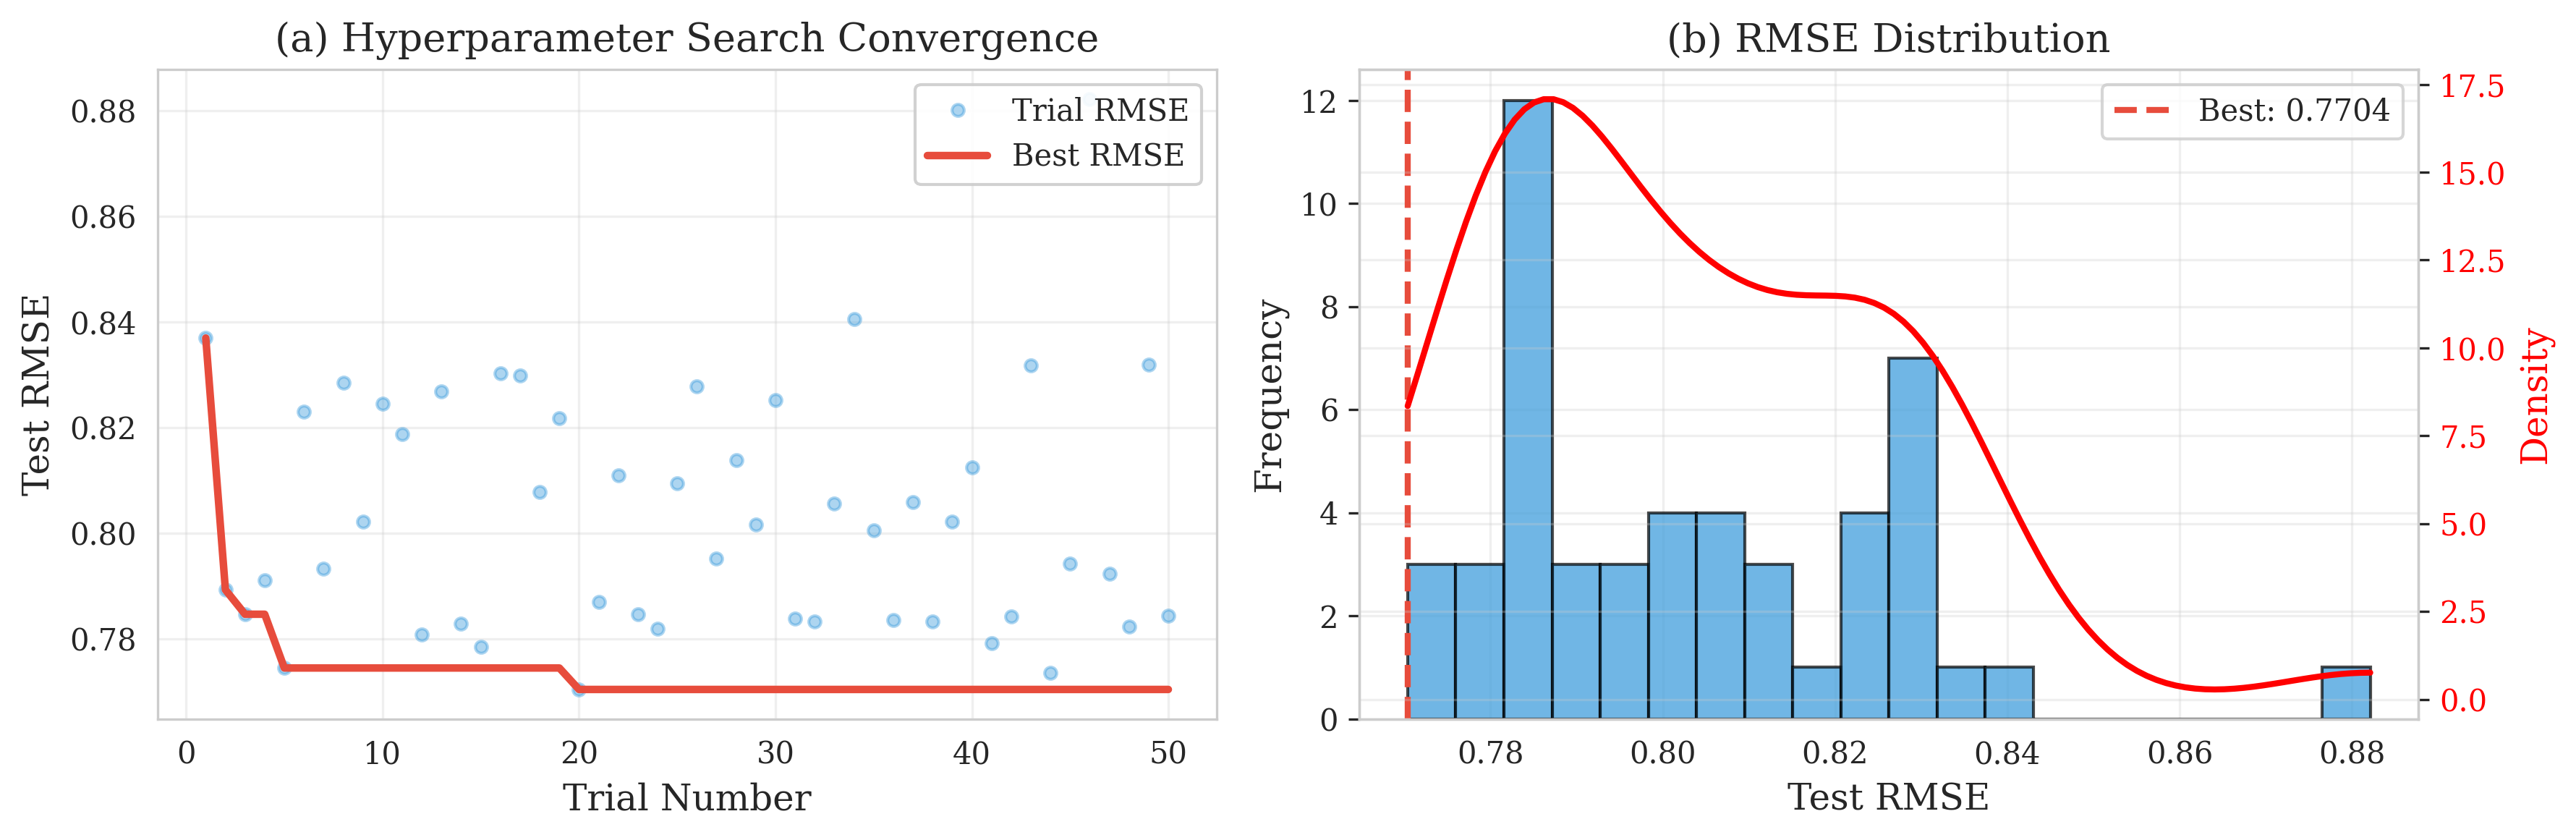

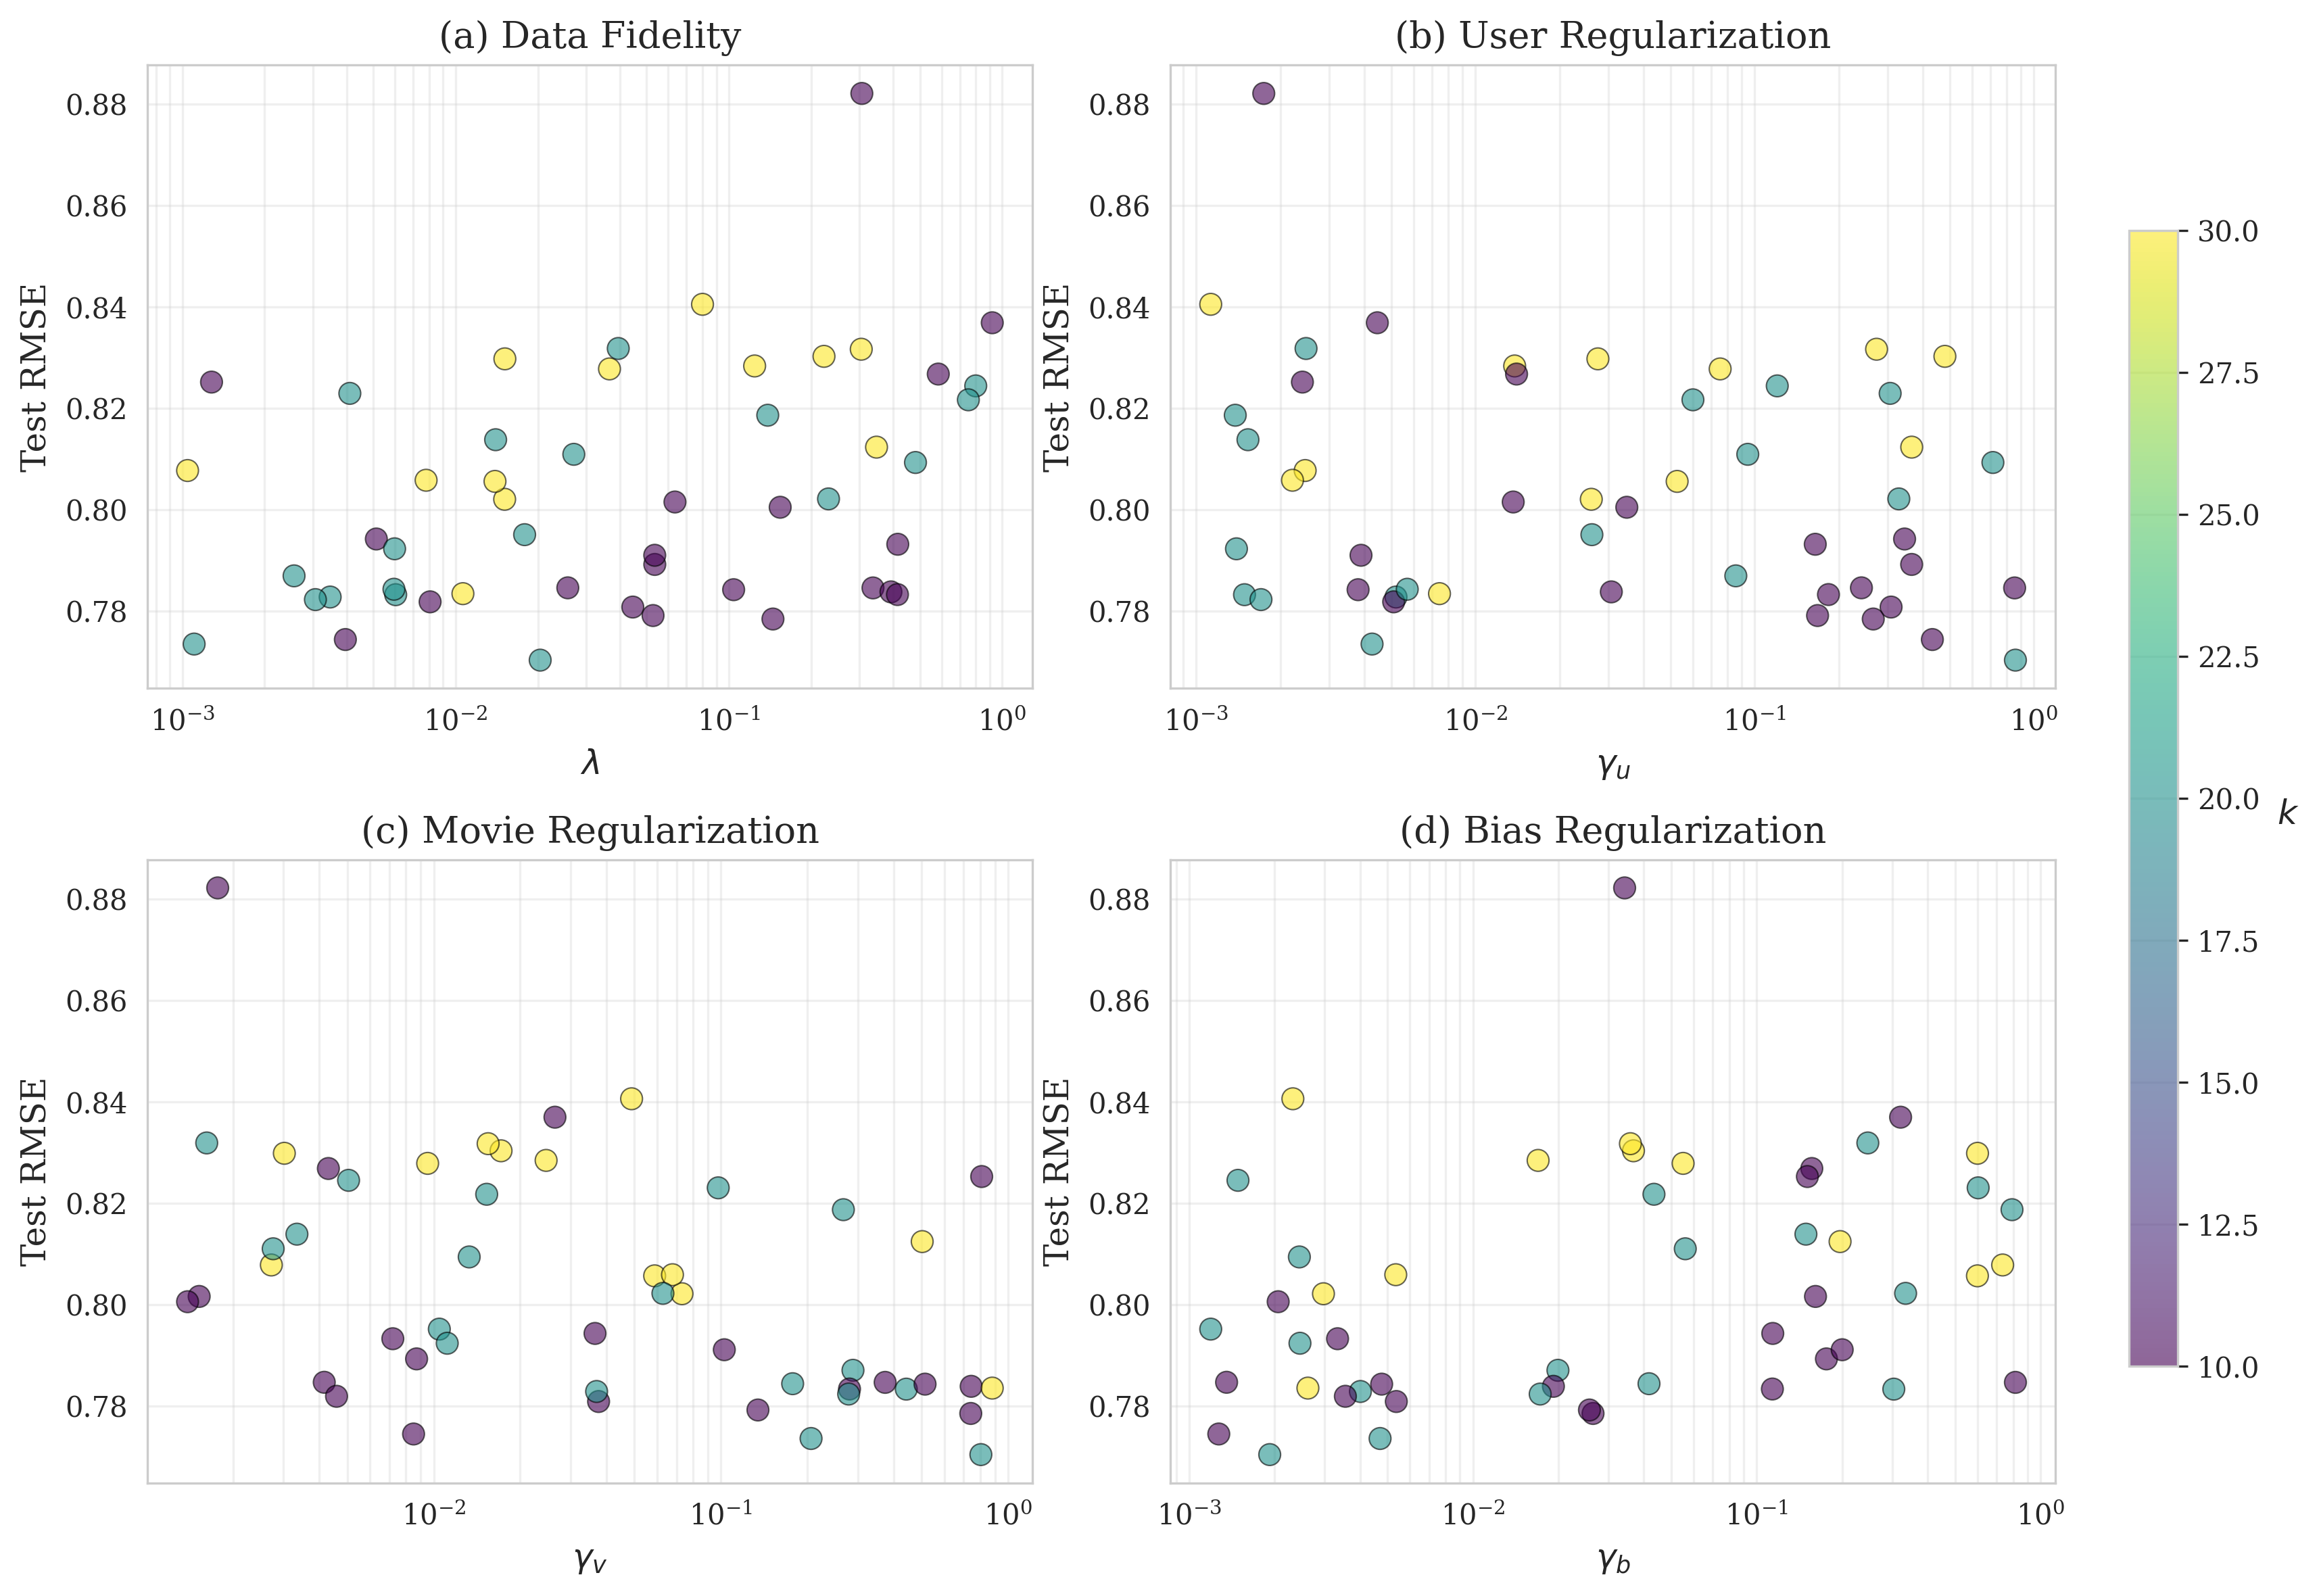


SUMMARY STATISTICS

Best Test RMSE: 0.770391
Mean Test RMSE: 0.803397 +/- 0.022849
Median Test RMSE: 0.801055

Best Configuration:
  k = 20
  lambda = 0.020393
  gamma_u = 0.858755
  gamma_v = 0.803412
  gamma_b = 0.001924

Search Efficiency:
  Total trials: 50
  Average time per trial: 452.32s
  Total search time: 376.93 minutes



In [50]:
# Set publication-quality style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
})

# Convergence Analysis (2x1)
fig1, axes = plt.subplots(1, 2, figsize=(12, 4))

# (a) RMSE Convergence
ax = axes[0]
trial_nums = results_df.index + 1
ax.plot(trial_nums, results_df['test_rmse'], 'o', alpha=0.4, markersize=4, 
        color='#3498db', label='Trial RMSE')
ax.plot(trial_nums, results_df['test_rmse'].cummin(), '-', linewidth=2.5, 
        color='#e74c3c', label='Best RMSE')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Test RMSE')
ax.set_title('(a) Hyperparameter Search Convergence')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3)

# (b) RMSE Distribution
ax = axes[1]
n, bins, patches = ax.hist(results_df['test_rmse'], bins=20, 
                            color='#3498db', alpha=0.7, edgecolor='black')
# KDE overlay
from scipy import stats
kde = stats.gaussian_kde(results_df['test_rmse'])
x_range = np.linspace(results_df['test_rmse'].min(), 
                      results_df['test_rmse'].max(), 100)
ax2 = ax.twinx()
ax2.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
ax2.set_ylabel('Density', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Mark best RMSE
best_rmse = results_df['test_rmse'].min()
ax.axvline(best_rmse, color='#e74c3c', linestyle='--', linewidth=2, 
           label=f'Best: {best_rmse:.4f}')
ax.set_xlabel('Test RMSE')
ax.set_ylabel('Frequency')
ax.set_title('(b) RMSE Distribution')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('fig_convergence.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig_convergence.png', dpi=300, bbox_inches='tight')
print("Saved: fig_convergence.pdf/png")
plt.show()


# Hyperparameter Impact Analysis

fig, axes = plt.subplots(2, 2, figsize=(12, 8))


# (a) Lambda – Data Fidelity
ax = axes[0, 0]
sc1 = ax.scatter(
    results_df['lamda'],
    results_df['test_rmse'],
    c=results_df['k'],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Test RMSE')
ax.set_title('(a) Data Fidelity')
ax.grid(True, alpha=0.3, which='both')

# (b) Gamma_u – User Regularization
ax = axes[0, 1]
sc2 = ax.scatter(
    results_df['gamma_u'],
    results_df['test_rmse'],
    c=results_df['k'],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xscale('log')
ax.set_xlabel(r'$\gamma_u$')
ax.set_ylabel('Test RMSE')
ax.set_title('(b) User Regularization')
ax.grid(True, alpha=0.3, which='both')

# (c) Gamma_v – Movie Regularization
ax = axes[1, 0]
sc3 = ax.scatter(
    results_df['gamma_v'],
    results_df['test_rmse'],
    c=results_df['k'],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xscale('log')
ax.set_xlabel(r'$\gamma_v$')
ax.set_ylabel('Test RMSE')
ax.set_title('(c) Movie Regularization')
ax.grid(True, alpha=0.3, which='both')

# (d) Gamma_b – Bias Regularization
ax = axes[1, 1]
sc4 = ax.scatter(
    results_df['gamma_b'],
    results_df['test_rmse'],
    c=results_df['k'],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xscale('log')
ax.set_xlabel(r'$\gamma_b$')
ax.set_ylabel('Test RMSE')
ax.set_title('(d) Bias Regularization')
ax.grid(True, alpha=0.3, which='both')


plt.tight_layout()
fig.subplots_adjust(right=0.85) 
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7]) 

cbar = fig.colorbar(sc4, cax=cbar_ax)
cbar.set_label(r'$k$', rotation=0, labelpad=10)

plt.savefig('fig_hyperparameters_2x2.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig_hyperparameters_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

# SUMMARY STATISTICS
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nBest Test RMSE: {results_df['test_rmse'].min():.6f}")
print(f"Mean Test RMSE: {results_df['test_rmse'].mean():.6f} +/- {results_df['test_rmse'].std():.6f}")
print(f"Median Test RMSE: {results_df['test_rmse'].median():.6f}")

print("\nBest Configuration:")
best_idx = results_df['test_rmse'].idxmin()
best_config = results_df.loc[best_idx]
print(f"  k = {int(best_config['k'])}")
print(f"  lambda = {best_config['lamda']:.6f}")
print(f"  gamma_u = {best_config['gamma_u']:.6f}")
print(f"  gamma_v = {best_config['gamma_v']:.6f}")
print(f"  gamma_b = {best_config['gamma_b']:.6f}")

print(f"\nSearch Efficiency:")
print(f"  Total trials: {len(results_df)}")
print(f"  Average time per trial: {results_df['time_seconds'].mean():.2f}s")
print(f"  Total search time: {results_df['time_seconds'].sum()/60:.2f} minutes")

print("\n" + "="*80)

In [53]:
# Query methods

def get_user_ratings(self, userid):
    if userid not in self.userid_to_idx:
        return 0, []
    user_idx = self.userid_to_idx[userid]
    start = self.user_ptr[user_idx]
    end = self.user_ptr[user_idx + 1]
    movie_indices = self.csr_col_indices[start:end]
    ratings = self.csr_values[start:end]
    user_ratings = [(self.idx_to_movieid[m], float(r)) for m, r in zip(movie_indices, ratings)]
    return len(user_ratings), user_ratings

def get_movie_ratings(self, movieid):
    if movieid not in self.movieid_to_idx:
        return 0, []
    movie_idx = self.movieid_to_idx[movieid]
    start = self.movie_ptr[movie_idx]
    end = self.movie_ptr[movie_idx + 1]
    user_indices = self.csc_row_indices[start:end]
    ratings = self.csc_values[start:end]
    movie_ratings = [(self.idx_to_userid[u], float(r)) for u, r in zip(user_indices, ratings)]
    return len(movie_ratings), movie_ratings

def get_ratings(self, userid, movieid):
    if userid not in self.userid_to_idx or movieid not in self.movieid_to_idx:
        return 0
    user_idx = self.userid_to_idx[userid]
    movie_idx = self.movieid_to_idx[movieid]
    start = self.user_ptr[user_idx]
    end = self.user_ptr[user_idx + 1]
    movies = self.csr_col_indices[start:end]
    ratings = self.csr_values[start:end]
    idx = np.where(movies == movie_idx)[0]
    if len(idx) > 0:
        return float(ratings[idx[0]])
    return 0


In [54]:

# TRAINING FUNCTIONS (Wrapped for Numba)

def compute_loss(ratings_matrix, U, V, b_u, b_m, lamda, gamma_u, gamma_v, gamma_b, train=True):
    """
    Wrapper calling the Numba optimized loss function.
    """
    if train:
        user_ptr = ratings_matrix.user_ptr_train
        col_indices = ratings_matrix.csr_col_indices_train
        values = ratings_matrix.csr_values_train
    else:
        user_ptr = ratings_matrix.user_ptr_test
        col_indices = ratings_matrix.csr_col_indices_test
        values = ratings_matrix.csr_values_test

    return _numba_compute_loss(
        user_ptr, col_indices, values,
        U, V, b_u, b_m,
        lamda, gamma_u, gamma_v, gamma_b
    )


def train_als(ratings_matrix, k=30, lamda=0.001, gamma_u=0.05, gamma_v=0.05,
              gamma_b=0.001, iterations=10):
    """
    Optimized ALS training.
    Outer loop: Python (controls flow).
    Inner loops: Numba (controls math/iteration).
    """

    print("Initializing Parameters...")
    # Initialize parameters
    user_biases = np.zeros(ratings_matrix.number_of_users, dtype=np.float64)
    movie_biases = np.zeros(ratings_matrix.number_of_movies, dtype=np.float64)

    # Scaled initialization 
    user_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_users)).astype(np.float64)
    movie_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_movies)).astype(np.float64)

    # For plotting
    loss_history = []
    rmse_history = []
    rmse_test_history = []

    # Pre-fetch arrays to pass to Numba
    # User/CSR data
    user_ptr = ratings_matrix.user_ptr_train
    csr_cols = ratings_matrix.csr_col_indices_train
    csr_vals = ratings_matrix.csr_values_train

    # Movie/CSC data
    movie_ptr = ratings_matrix.movie_ptr_train
    csc_rows = ratings_matrix.csc_row_indices_train
    csc_vals = ratings_matrix.csc_values_train

    print(f"Starting {iterations} iterations of ALS (Numba Optimized)...")
    start_total = time.time()

    for iteration in range(iterations):
        iter_start = time.time()

        # 1. Update Users (Parallel Numba)
        _numba_update_users(
            user_ptr, csr_cols, csr_vals,
            user_embeddings, movie_embeddings, user_biases, movie_biases,
            k, lamda, gamma_u, gamma_b
        )

        # 2. Update Movies (Parallel Numba)
        _numba_update_movies(
            movie_ptr, csc_rows, csc_vals,
            user_embeddings, movie_embeddings, user_biases, movie_biases,
            k, lamda, gamma_v, gamma_b
        )

        # 3. Compute Loss (Parallel Numba)
        loss_train, rmse_train = compute_loss(
            ratings_matrix, user_embeddings, movie_embeddings,
            user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=True
        )

        loss_test, rmse_test = compute_loss(
            ratings_matrix, user_embeddings, movie_embeddings,
            user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=False
        )

        iter_time = time.time() - iter_start
        print(f"Iteration {iteration+1}/{iterations} [{iter_time:.2f}s]:\n "
              f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
              f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

        loss_history.append(loss_train)
        rmse_history.append(rmse_train)
        rmse_test_history.append(rmse_test)

    total_time = time.time() - start_total

    # Print summary statistics
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Training Time: {total_time:.2f}s")
    print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
    print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
    print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
    print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
    print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
    print("="*60)

    return user_embeddings, movie_embeddings, user_biases, movie_biases, loss_history, rmse_history, rmse_test_history

In [69]:
def plot_training_results(loss_history, rmse_history, rmse_test_history):

    iterations = np.arange(1, len(loss_history) + 1)

    # LOSS OVER ITERATIONS
    plt.figure(figsize=(10, 6))
    
    plt.plot(iterations, loss_history, marker='o', linewidth=2.5, markersize=7, 
             color='steelblue', label='Training Loss', alpha=0.8)
    
    plt.title("Training Loss over Iterations", fontsize=14, fontweight='bold')
    plt.xlabel("Iteration", fontsize=12, fontweight='bold')
    plt.ylabel("Loss", fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=11)

    plt.annotate(f'Start: {loss_history[0]:.4f}', 
                xy=(1, loss_history[0]), 
                xytext=(10, 15), textcoords='offset points',
                fontsize=10, color='steelblue', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='steelblue'))
    
    plt.annotate(f'Final: {loss_history[-1]:.4f}', 
                xy=(len(loss_history), loss_history[-1]), 
                xytext=(-60, -20), textcoords='offset points',
                fontsize=10, color='steelblue', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='steelblue'))
    
    
    plt.tight_layout()
    plt.savefig('loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # TRAIN VS TEST RMSE (OVERFITTING ANALYSIS)
    plt.figure(figsize=(12, 7))
    
    # Plot train and test RMSE
    plt.plot(iterations, rmse_history, marker='o', linewidth=2.5, markersize=7,
             color='darkorange', label='Train RMSE', alpha=0.8)
    plt.plot(iterations, rmse_test_history, marker='s', linewidth=2.5, markersize=7,
             color='forestgreen', label='Test RMSE', alpha=0.8)
    
    # Fill the gap between train and test to show overfitting
    plt.fill_between(iterations, rmse_history, rmse_test_history, 
                     where=(np.array(rmse_test_history) >= np.array(rmse_history)),
                     alpha=0.2, color='red', label='Generalization Gap')
    
    # Calculate gaps and improvements
    final_gap = rmse_test_history[-1] - rmse_history[-1]
    final_gap_pct = (final_gap / rmse_test_history[-1]) * 100
    improvement_train = ((rmse_history[0] - rmse_history[-1]) / rmse_history[0]) * 100
    improvement_test = ((rmse_test_history[0] - rmse_test_history[-1]) / rmse_test_history[0]) * 100
    
    # Annotations for final values
    plt.annotate(f'Train: {rmse_history[-1]:.4f}', 
                xy=(len(rmse_history), rmse_history[-1]), 
                xytext=(15, -20), textcoords='offset points',
                fontsize=10, color='darkorange', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='darkorange', lw=1.5))
    
    plt.annotate(f'Test: {rmse_test_history[-1]:.4f}', 
                xy=(len(rmse_test_history), rmse_test_history[-1]), 
                xytext=(15, 15), textcoords='offset points',
                fontsize=10, color='forestgreen', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='forestgreen', lw=1.5))
    
    # Title and labels
    plt.title("Train vs Test RMSE over Iterations", fontsize=14, fontweight='bold')
    plt.xlabel("Iteration", fontsize=12, fontweight='bold')
    plt.ylabel("RMSE", fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()



In [66]:

# ============================================================================
# EXECUTION BLOCK
# ============================================================================
if __name__ == "__main__":
    try:
        k = 20
        lamda = 0.02039307537342147
        gamma_u = 0.8587551700375037
        gamma_v = 0.8034116286188123
        gamma_b = 0.00192377578961482
        iterations = 20

        # Train
        user_embeddings, movie_embeddings, user_biases, movie_biases, \
            loss_history, rmse_history, rmse_test_history = train_als(
                ratings_matrix, k=k, lamda=lamda, gamma_u=gamma_u, gamma_v=gamma_v,
                gamma_b=gamma_b, iterations=iterations
            )

    except OSError:
        print("Error: 'ratings.csv' not found. Please ensure the file is in the working directory.")

Initializing Parameters...
Starting 20 iterations of ALS (Numba Optimized)...
Iteration 1/20 [5.70s]:
 Train RMSE = 0.8433, Train Loss = 215981.7681 
 Test  RMSE = 0.8658, Test  Loss = 31640.8371

Iteration 2/20 [5.32s]:
 Train RMSE = 0.7494, Train Loss = 183073.6172 
 Test  RMSE = 0.8088, Test  Loss = 39509.0439

Iteration 3/20 [5.18s]:
 Train RMSE = 0.7241, Train Loss = 175802.3113 
 Test  RMSE = 0.7886, Test  Loss = 42153.2063

Iteration 4/20 [5.19s]:
 Train RMSE = 0.7153, Train Loss = 173458.7666 
 Test  RMSE = 0.7809, Test  Loss = 43127.4633

Iteration 5/20 [5.26s]:
 Train RMSE = 0.7110, Train Loss = 172361.1886 
 Test  RMSE = 0.7770, Test  Loss = 43608.2389

Iteration 6/20 [5.25s]:
 Train RMSE = 0.7087, Train Loss = 171760.9286 
 Test  RMSE = 0.7748, Test  Loss = 43882.3455

Iteration 7/20 [5.26s]:
 Train RMSE = 0.7072, Train Loss = 171403.2489 
 Test  RMSE = 0.7735, Test  Loss = 44051.8128

Iteration 8/20 [5.17s]:
 Train RMSE = 0.7063, Train Loss = 171176.3756 
 Test  RMSE = 0.7

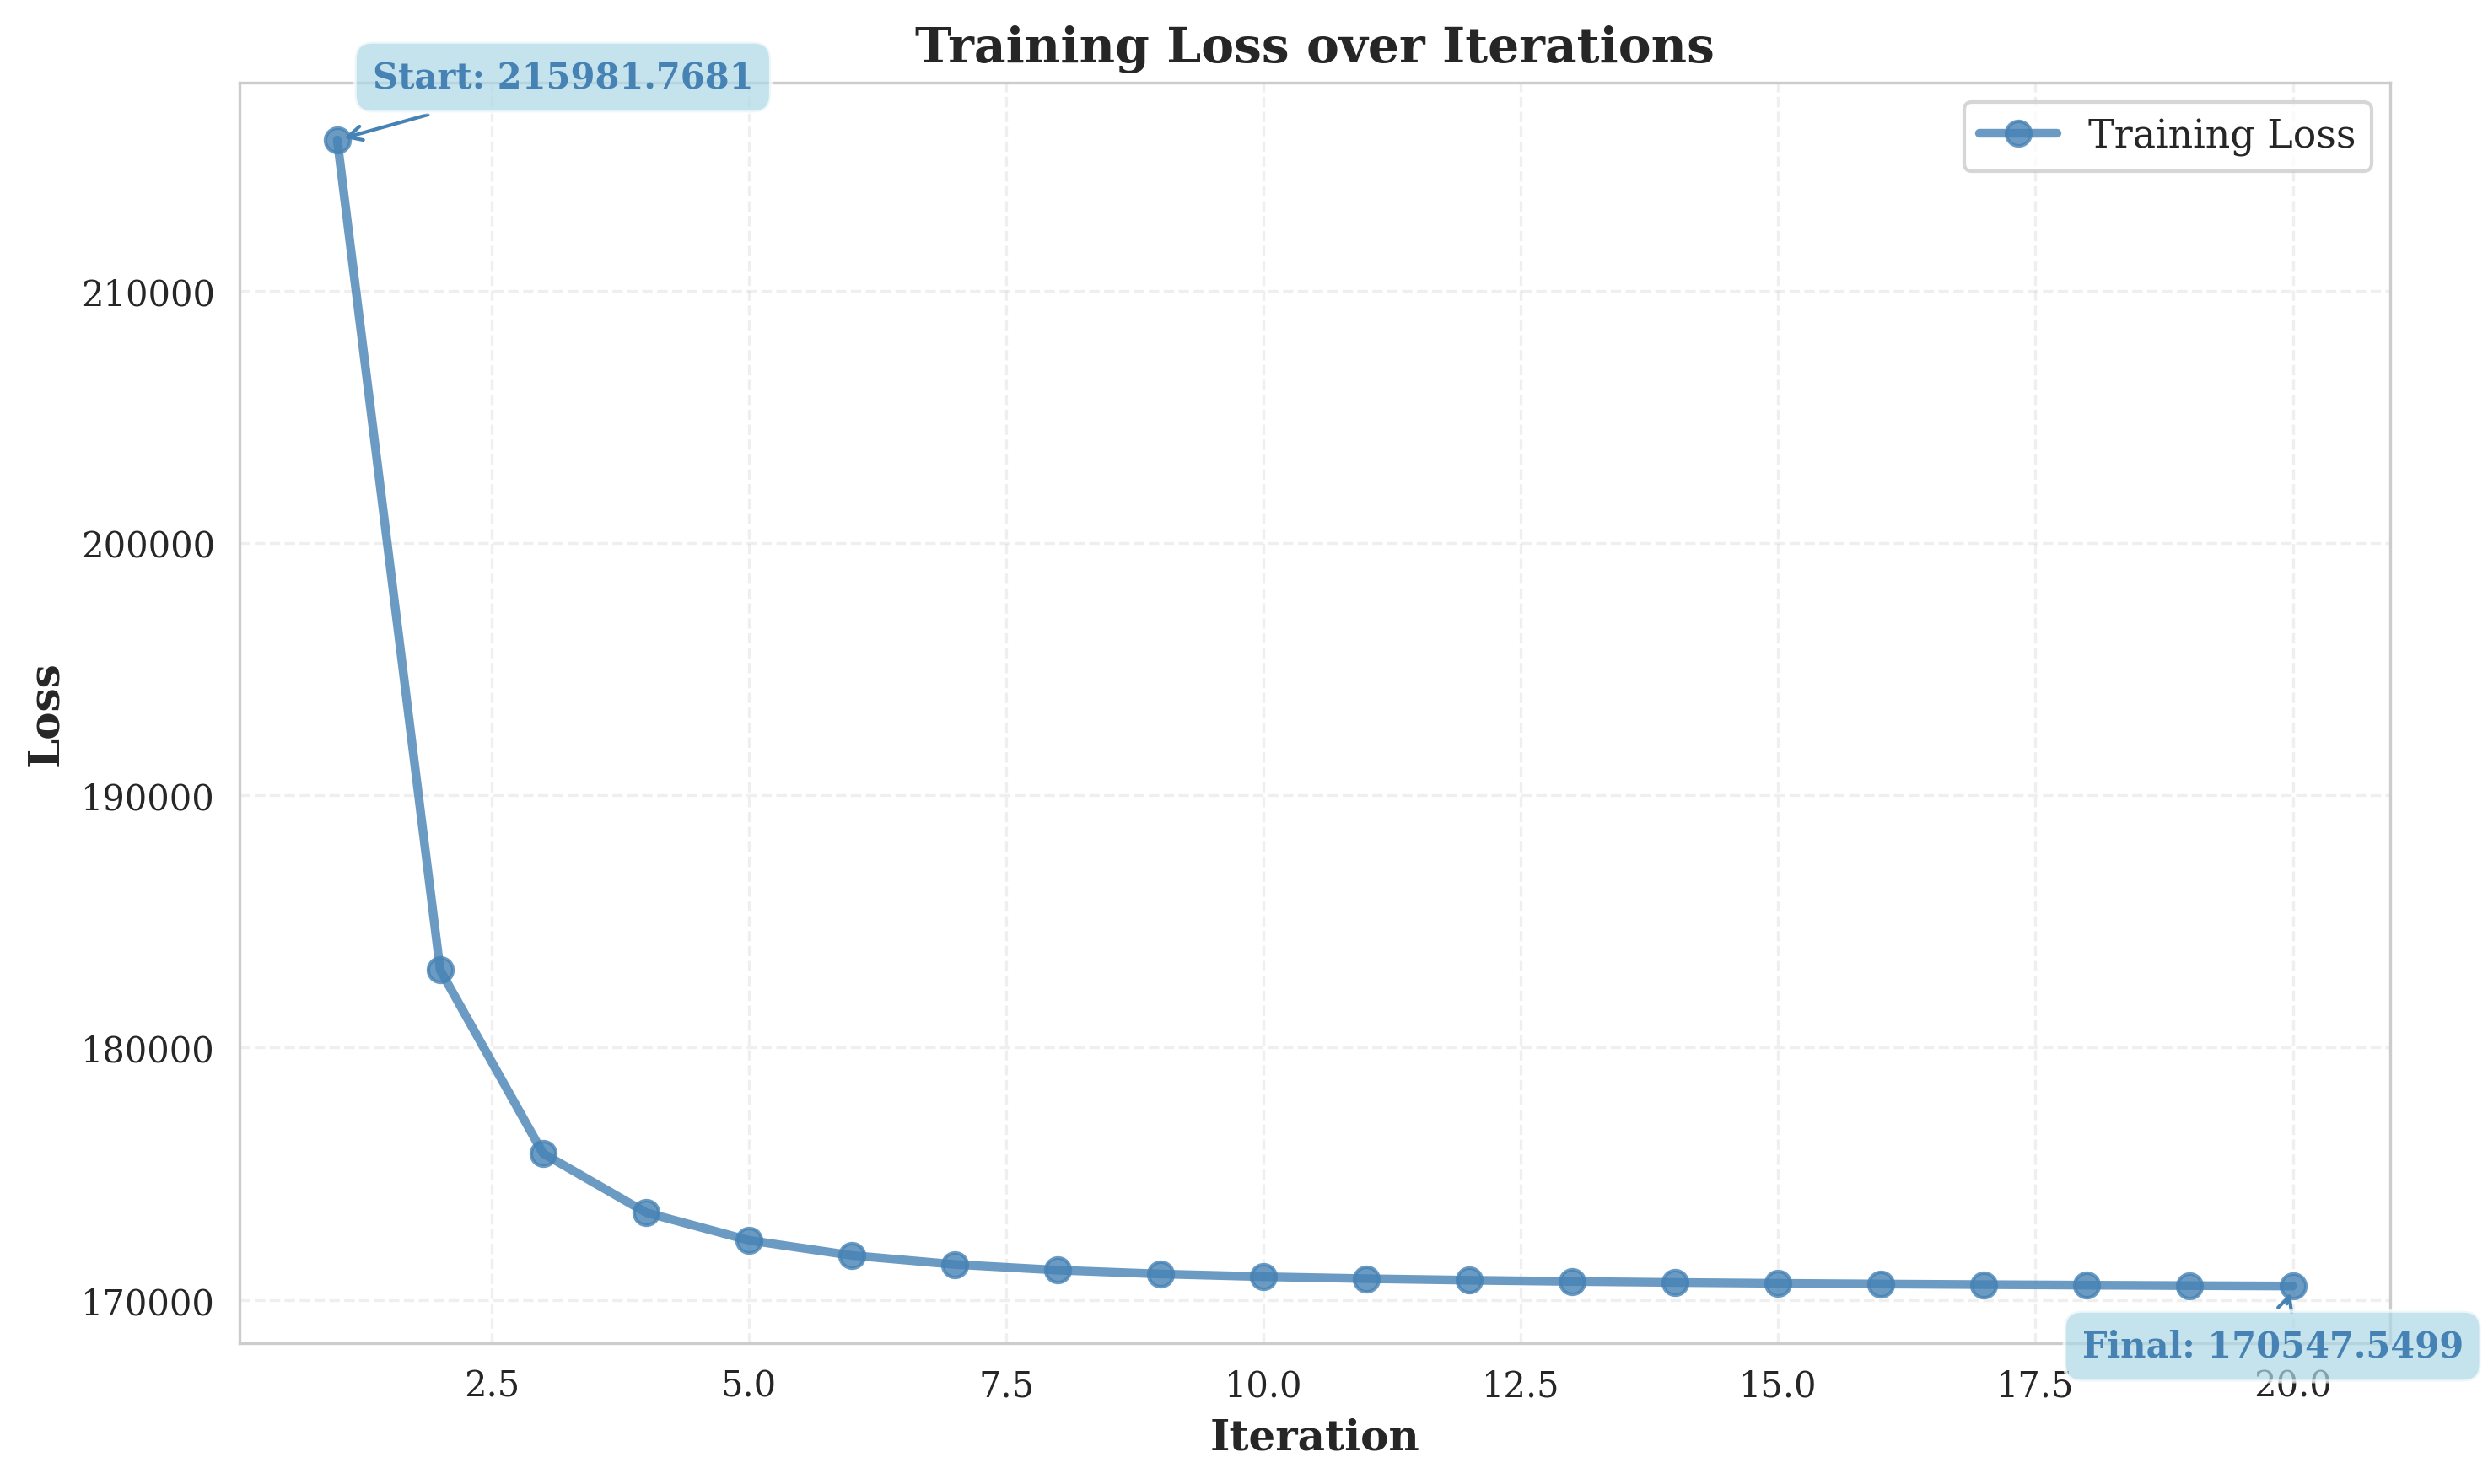

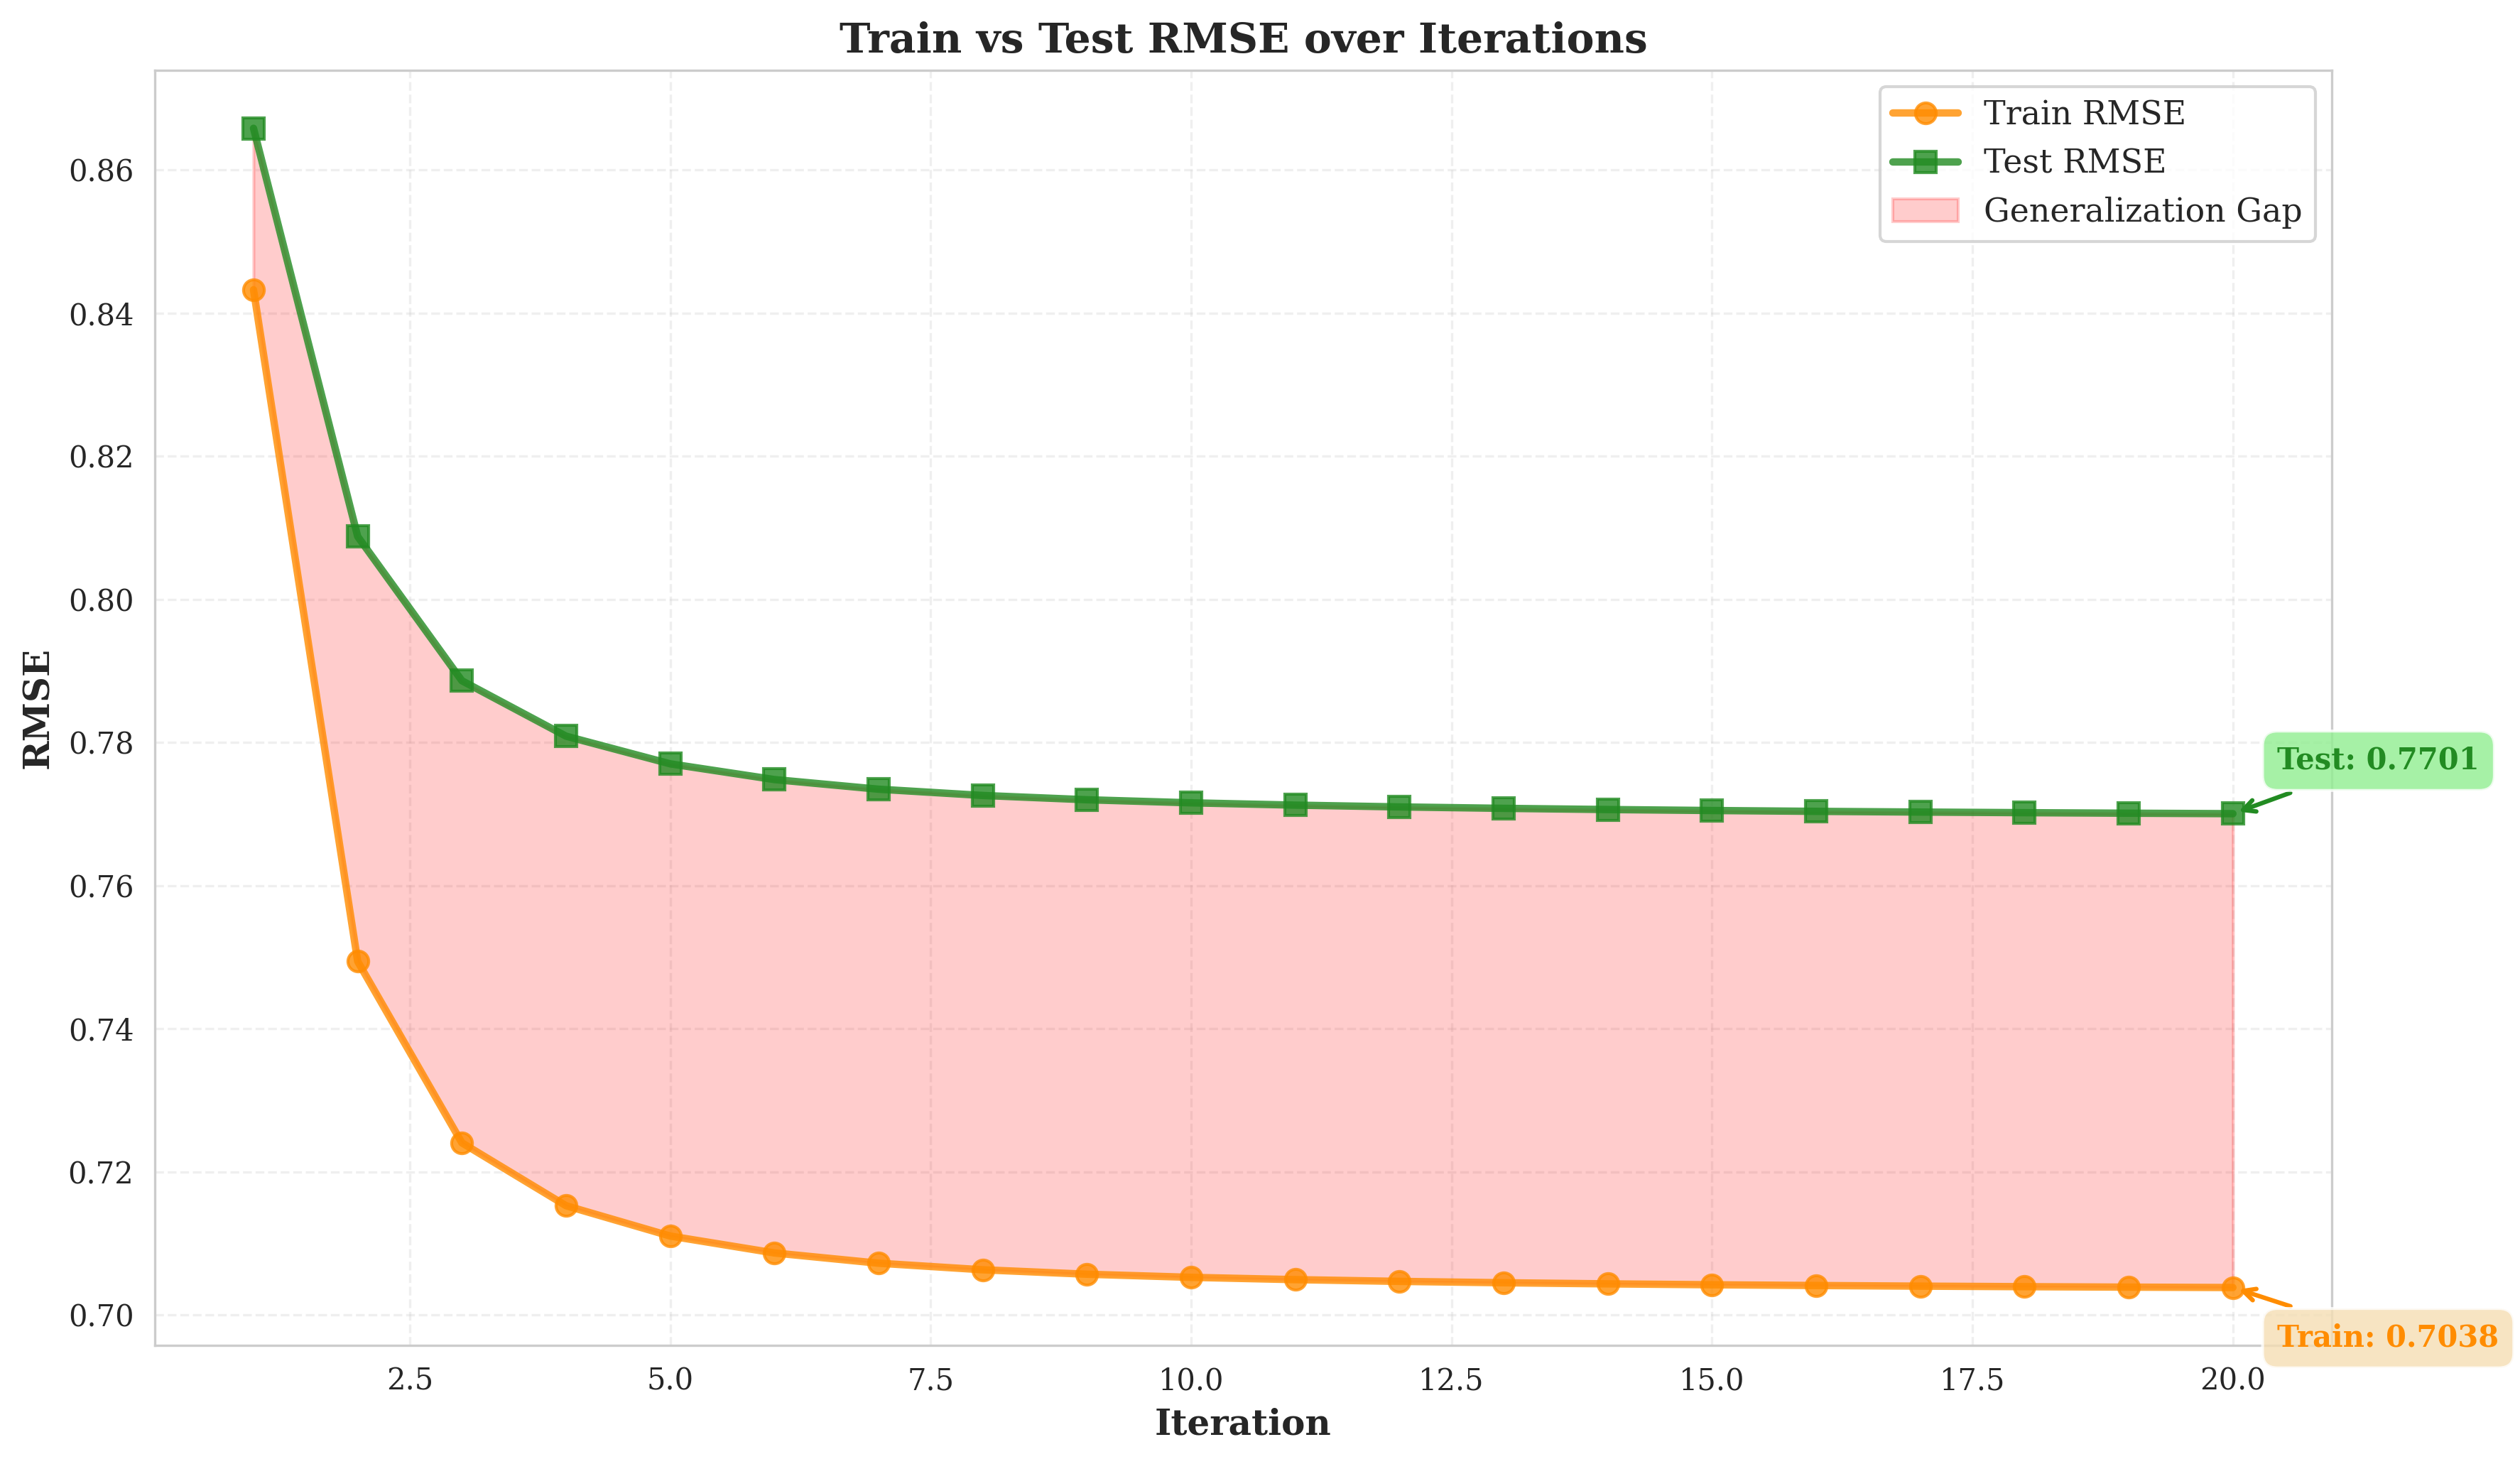

In [70]:
plot_training_results(loss_history, rmse_history, rmse_test_history)


# Testing Recommendation for a Dummy User

In [71]:
# Load movies metadata
try:
    df2 = pd.read_csv('movies.csv')
except FileNotFoundError:
    print("Warning: 'movies.csv' not found. Creating dummy dataframe.")
    df2 = pd.DataFrame({'movieId': range(10000), 'title': ['Movie']*10000, 'genres': ['Drama']*10000})

In [72]:

# ============================================================================
# NUMBA KERNELS
# ============================================================================

@njit(fastmath=True)
def _numba_dummy_train_kernel(movie_indices, rating_values, V, b_m,
                              lamda, gamma_u, gamma_b, k, iterations):
    """
    Numba kernel to train a single user vector.
    FIX: Replaced try-except with direct np.linalg.lstsq for stability.
    """
    # Initialize random embedding
    dummy_user_embedding = np.random.normal(0, 0.1, size=(k,)).astype(np.float64)
    dummy_bias = 0.0
    n_ratings = len(movie_indices)

    # Pre-allocate identity matrix scaled by gamma_u
    eye_k = np.eye(k, dtype=np.float64) * gamma_u

    for _ in range(iterations):
        # 1. Update Bias
        bias_sum = 0.0
        for i in range(n_ratings):
            m_idx = movie_indices[i]
            r = rating_values[i]

            # Dot product: dummy_emb @ V[:, m_idx]
            dot_val = 0.0
            for f in range(k):
                dot_val += dummy_user_embedding[f] * V[f, m_idx]

            pred = b_m[m_idx] + dot_val
            bias_sum += lamda * (r - pred)

        dummy_bias = bias_sum / (lamda * n_ratings + gamma_b)

        # 2. Update Embedding
        first_term = eye_k.copy()
        second_term = np.zeros(k, dtype=np.float64)

        for i in range(n_ratings):
            m_idx = movie_indices[i]
            r = rating_values[i]

            # Update second term: v_n * (rating - bias - b_m)
            residual = r - dummy_bias - b_m[m_idx]

            # Manual outer product accumulation for speed
            factor = lamda
            for r_idx in range(k):
                v_r = V[r_idx, m_idx]
                second_term[r_idx] += factor * v_r * residual

                for c_idx in range(k):
                    first_term[r_idx, c_idx] += factor * v_r * V[c_idx, m_idx]

        # FIX: Use lstsq directly. It handles both singular and non-singular matrices.
        # rcond=-1 tells LAPACK to use machine precision default
        dummy_user_embedding = np.linalg.lstsq(first_term, second_term, rcond=-1)[0]

    return dummy_user_embedding, dummy_bias


@njit(parallel=True, fastmath=True)
def _numba_calculate_scores(dummy_emb, V, dummy_bias, b_m, movie_ptr):
    """
    Calculates scores for all movies in parallel.
    """
    n_movies = V.shape[1]
    k = V.shape[0]
    scores = np.zeros(n_movies, dtype=np.float64)

    for m in prange(n_movies):
        # Check rating count using the pointer structure
        count = movie_ptr[m+1] - movie_ptr[m]

        if count < 100:
            scores[m] = 0.0
        else:
            # Dot product
            dot_val = 0.0
            for f in range(k):
                dot_val += dummy_emb[f] * V[f, m]

            scores[m] = dot_val + (b_m[m] * 0.05)

    return scores


@njit(parallel=True, fastmath=True)
def _numba_calc_norms(V):
    """Calculate L2 norm of every movie column"""
    n_movies = V.shape[1]
    norms = np.zeros(n_movies, dtype=np.float64)
    for m in prange(n_movies):
        col_sum = 0.0
        for f in range(V.shape[0]):
            val = V[f, m]
            col_sum += val * val
        norms[m] = np.sqrt(col_sum)
    return norms



In [73]:
# WRAPPER FUNCTIONS

def dummy_user_train(dummy_user_ratings, movie_embeddings, movie_biases, lamda, gamma_u, gamma_b, k=10, iterations=10):
    if len(dummy_user_ratings) == 0:
        return np.zeros(k), 0.0

    # Convert inputs to Numba-friendly arrays
    indices = np.array([x[0] for x in dummy_user_ratings], dtype=np.int32)
    values = np.array([x[1] for x in dummy_user_ratings], dtype=np.float64)

    return _numba_dummy_train_kernel(
        indices, values, movie_embeddings, movie_biases,
        lamda, gamma_u, gamma_b, k, iterations
    )

def dummy_user_recommendation(dummy_user_embedding, movie_embeddings, dummy_bias, movie_biases):
    # Use movie_ptr from global 'ratings_matrix' for counts
    score = _numba_calculate_scores(
        dummy_user_embedding,
        movie_embeddings,
        dummy_bias,
        movie_biases,
        ratings_matrix.movie_ptr
    )

    ranked_items = np.argsort(score)[::-1]
    return score, ranked_items



In [90]:
# EXECUTION

# 1. Setup Dummy User
dummy_movie_ids = [4896]  #
dummy_ratings = [5.0]
dummy_movie_idx = []
dummy_user_ratings = []
n_rec = 15

for id, rating in zip(dummy_movie_ids, dummy_ratings):
    if id in ratings_matrix.movieid_to_idx:
        mov_idx = ratings_matrix.movieid_to_idx[id]
        dummy_movie_idx.append(mov_idx)
        dummy_user_ratings.append((mov_idx, rating))

# 2. Train
dummy_user_embidding, dummy_bias = dummy_user_train(
    dummy_user_ratings,
    movie_embeddings,
    movie_biases,
    lamda=lamda,
    gamma_u=gamma_u,
    gamma_b=gamma_b,
    k=k,
    iterations=iterations
)

# 3. Predict
score, ranked_items = dummy_user_recommendation(dummy_user_embidding, movie_embeddings, dummy_bias, movie_biases)

# 4. Filter & Display Recommendations
top_recommendations = []
for i in range(len(ranked_items)):
    if ranked_items[i] not in dummy_movie_idx:
        top_recommendations.append(ranked_items[i])
    if len(top_recommendations) >= n_rec:
        break

print("\n" + "="*60)
print("RECOMMENDATION RESULTS")
print("="*60)
for i in range(len(top_recommendations)):
    rec_idx = top_recommendations[i]
    rec_id = ratings_matrix.idx_to_movieid[rec_idx]
    try:
        row = df2[df2['movieId'] == rec_id][['title', 'genres']].values[0]
        print(f"{i+1}. {row[0]} ({row[1]})")
    except IndexError:
        print(f"{i+1}. Movie ID {rec_id} (Title Not Found)")
print("\n" + "="*60)
print("DEBUGGING DUMMY USER")
print("="*60)

print("\nRated Movies:")
for movie_id in dummy_movie_ids:
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]} ({row[1]})")
    except:
        pass

print(f"\nDummy user embedding norm: {np.linalg.norm(dummy_user_embidding):.4f}")
print(f"Dummy user bias: {dummy_bias:.4f}")

print(f"\nScore statistics:")
print(f"  Min: {score.min():.4f}, Max: {score.max():.4f}, Mean: {score.mean():.4f}")




RECOMMENDATION RESULTS
1. Harry Potter and the Prisoner of Azkaban (2004) (Adventure|Fantasy|IMAX)
2. Harry Potter and the Chamber of Secrets (2002) (Adventure|Fantasy)
3. Harry Potter and the Half-Blood Prince (2009) (Adventure|Fantasy|Mystery|Romance|IMAX)
4. Harry Potter and the Goblet of Fire (2005) (Adventure|Fantasy|Thriller|IMAX)
5. Harry Potter and the Deathly Hallows: Part 1 (2010) (Action|Adventure|Fantasy|IMAX)
6. Harry Potter and the Deathly Hallows: Part 2 (2011) (Action|Adventure|Drama|Fantasy|Mystery|IMAX)
7. Harry Potter and the Order of the Phoenix (2007) (Adventure|Drama|Fantasy|IMAX)
8. Pirates of the Caribbean: The Curse of the Black Pearl (2003) (Action|Adventure|Comedy|Fantasy)
9. Lord of the Rings: The Fellowship of the Ring, The (2001) (Adventure|Fantasy)
10. Lord of the Rings: The Two Towers, The (2002) (Adventure|Fantasy)
11. Lord of the Rings: The Return of the King, The (2003) (Action|Adventure|Drama|Fantasy)
12. Pirates of the Caribbean: Dead Man's Chest (

In [75]:
# POLARIZING MOVIES

print("\n" + "="*60)
print("POLARIZING MOVIES")
print("="*60)

n_polorizing_movies = 30
norms = _numba_calc_norms(movie_embeddings)
movies_idx_sorted_by_norm = np.argsort(norms)[::-1]
polorizing_movies_id = [ratings_matrix.idx_to_movieid[idx] for idx in movies_idx_sorted_by_norm[:n_polorizing_movies]]

for movie_id in polorizing_movies_id:
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]} ({row[1]})")
    except IndexError:
        pass


POLARIZING MOVIES
Lord of the Rings: The Fellowship of the Ring, The (2001) (Adventure|Fantasy)
Lord of the Rings: The Return of the King, The (2003) (Action|Adventure|Drama|Fantasy)
Lord of the Rings: The Two Towers, The (2002) (Adventure|Fantasy)
Star Wars: Episode IV - A New Hope (1977) (Action|Adventure|Sci-Fi)
Pulp Fiction (1994) (Comedy|Crime|Drama|Thriller)
Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Sci-Fi)
Star Wars: Episode VI - Return of the Jedi (1983) (Action|Adventure|Sci-Fi)
Dumb & Dumber (Dumb and Dumber) (1994) (Adventure|Comedy)
Matrix, The (1999) (Action|Sci-Fi|Thriller)
Ace Ventura: Pet Detective (1994) (Comedy)
Kill Bill: Vol. 1 (2003) (Action|Crime|Thriller)
Star Wars: Episode I - The Phantom Menace (1999) (Action|Adventure|Sci-Fi)
Forrest Gump (1994) (Comedy|Drama|Romance|War)
Natural Born Killers (1994) (Action|Crime|Thriller)
Blair Witch Project, The (1999) (Drama|Horror|Thriller)
Kill Bill: Vol. 2 (2004) (Action|Drama|Thriller)
Sil

In [91]:
n_least_polarizing_movies = 10

# Get indices sorted by norm
least_polarizing_idx = np.argsort(norms)[:n_least_polarizing_movies]

print("LEAST POLARIZING MOVIES (Smallest embedding norms):")
print("-" * 80)

for idx in least_polarizing_idx:
    movie_id = ratings_matrix.idx_to_movieid[idx]
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]:<50} | {row[1]:<30} | Norm: {norms[idx]:.4f}")
    except IndexError:
        continue  

LEAST POLARIZING MOVIES (Smallest embedding norms):
--------------------------------------------------------------------------------
So This Is Love (1953)                             | (no genres listed)             | Norm: 0.0000
Pictures from Life's Other Side (1971)             | (no genres listed)             | Norm: 0.0000
Recipe for a Perfect Christmas (2005)              | (no genres listed)             | Norm: 0.0000
Scarlet Angel (1952)                               | Adventure|Drama|Western        | Norm: 0.0000
Matching Jack (2010)                               | Drama                          | Norm: 0.0000
Vinaro Bhagyamu Vishnu Katha (2023)                | Action|Comedy|Romance          | Norm: 0.0000
The Mafia Triangle (1981)                          | Crime|Drama                    | Norm: 0.0000
Like Everyone Else (1944)                          | Comedy|Romance                 | Norm: 0.0000
Money: A Tragicomic Saga (1946)                    | Comedy                

## PCA visualization

In [76]:
# NUMBA KERNELS (Standardization & PCA)

@njit(parallel=True)
def _numba_standard_scaler(data):
    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in prange(n_features):
        # 1. Compute Mean/Std
        col_sum = 0.0
        col_sq_sum = 0.0
        for i in range(n_samples):
            col_sum += data[i, j]
            col_sq_sum += data[i, j]**2

        mean = col_sum / n_samples
        # Population variance (StandardScaler default)
        var = (col_sq_sum / n_samples) - (mean * mean)
        std = np.sqrt(var) if var > 0 else 1.0

        # 2. Normalize
        for i in range(n_samples):
            scaled[i, j] = (data[i, j] - mean) / std

    return scaled

@njit
def _numba_pca_2d(data):
    n_samples = data.shape[0]
    # Sample Covariance Matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort descending
    idx = np.argsort(eig_vals)[::-1]
    components = eig_vecs[:, idx[:2]]

    return data @ components


@njit(parallel=True)
def get_movie_counts_numba(movie_ptr):
    """
    Fast calculation of rating counts per movie using the CSC pointers.
    """
    n_movies = len(movie_ptr) - 1
    counts = np.zeros(n_movies, dtype=np.int32)

    for m in prange(n_movies):
        counts[m] = movie_ptr[m+1] - movie_ptr[m]

    return counts



Running Numba Optimized PCA...
Original Data Shape: (20, 84432)
Reduced Data Shape: (84432, 2)



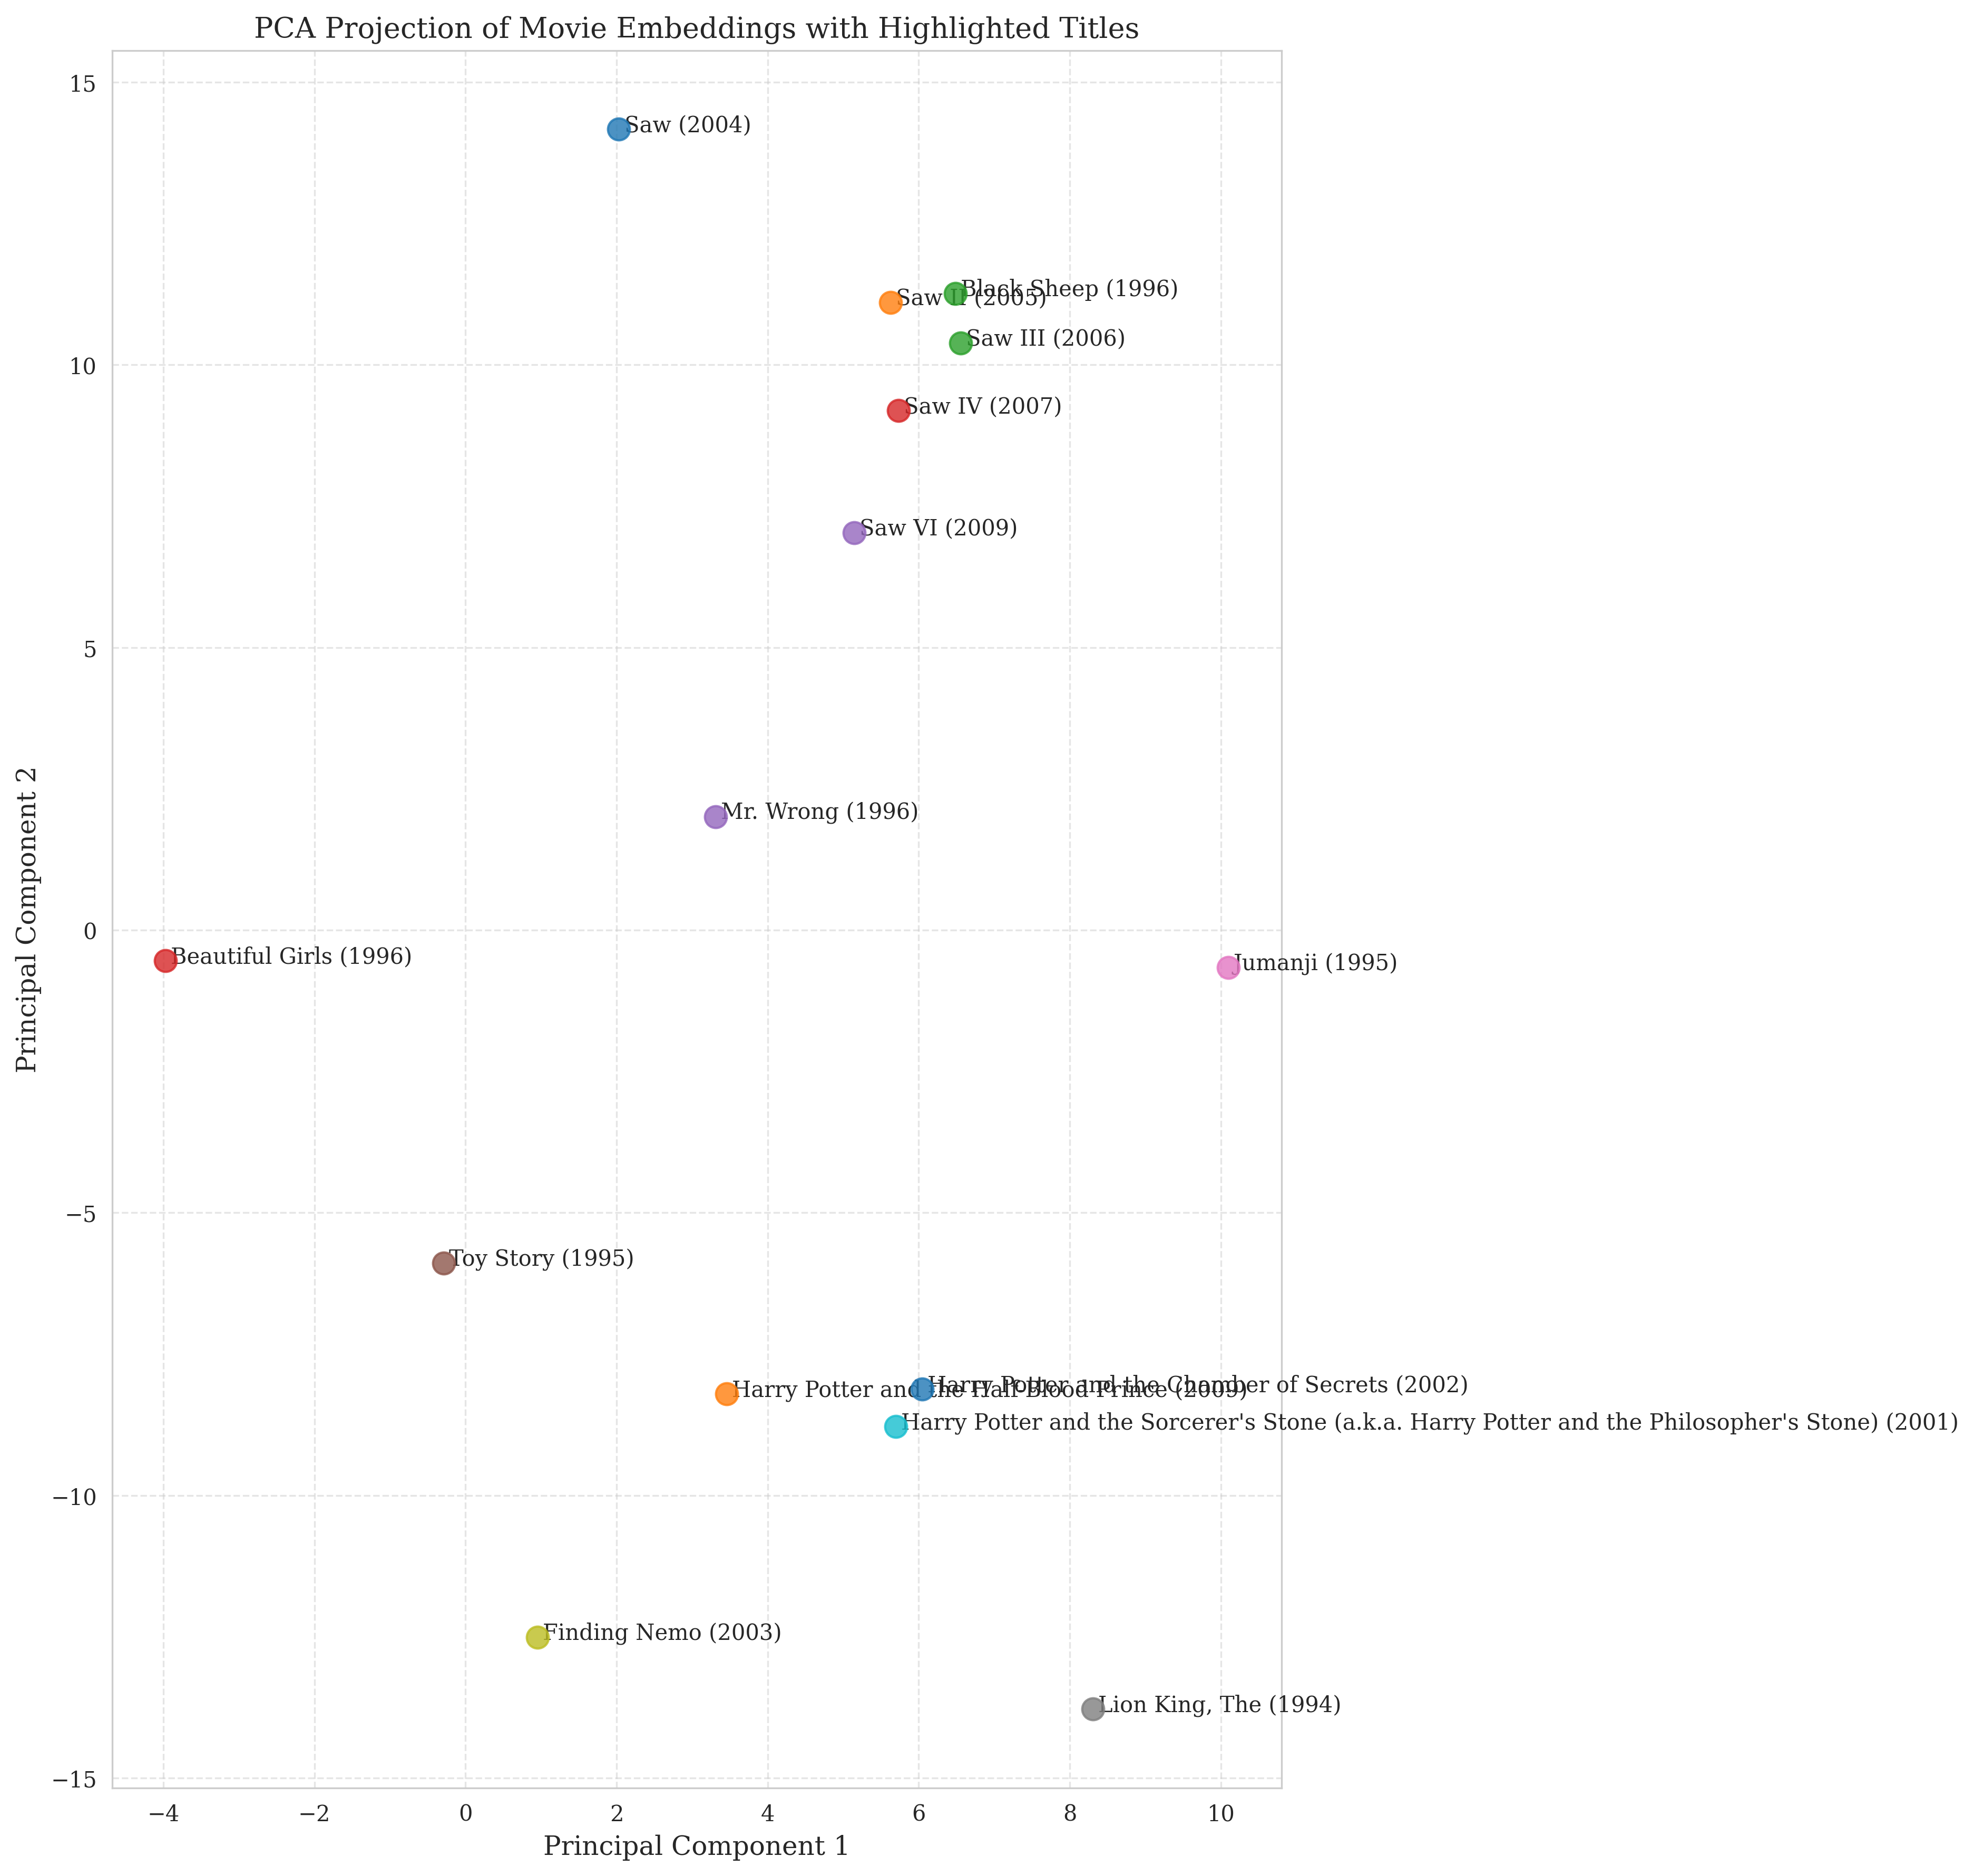

In [78]:
# EXECUTION & PLOTTING

# 1. Transpose (Users as features, Movies as samples for the plot)
X_input = movie_embeddings.T

# 2. Standardize (Numba)
Standarized_movie_embeddings = _numba_standard_scaler(X_input)

# 3. PCA (Numba)
movie_embeddings_2D = _numba_pca_2d(Standarized_movie_embeddings)

print("Original Data Shape:", movie_embeddings.shape)
print("Reduced Data Shape:", movie_embeddings_2D.shape)
print()

# 4. Plotting
movie_ids_plot = [8957, 39446, 48877, 55577, 72129, 1, 2, 364, 6377, 4896, 5816, 69844, 88, 94, 102]

plt.figure(figsize=(12, 12))
plt.title("PCA Projection of Movie Embeddings with Highlighted Titles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)

offset = 0.07

# Iterate and Plot
for movie in movie_ids_plot:
    if movie in ratings_matrix.movieid_to_idx:
        movie_idx_plot = ratings_matrix.movieid_to_idx[movie]

        movie_x = movie_embeddings_2D[movie_idx_plot, 0]
        movie_y = movie_embeddings_2D[movie_idx_plot, 1]

        plt.scatter(movie_x, movie_y, s=100, alpha=0.8, zorder=5)

        # Retrieve Title safely
        try:
            row = df2[df2['movieId'] == movie][['title']].values[0][0]
            plt.annotate(
                row,
                (movie_x, movie_y),
                xytext=(movie_x + offset, movie_y + offset),
                fontsize=10,
                textcoords='data',
                ha='left',
                va='center'
            )
        except IndexError:
            print(f"Title not found for ID {movie}")

plt.tight_layout()
plt.savefig('pca_movies.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

1. Sorting movies by popularity...
2. Collecting top 100 movies for: ['Children', 'Horror', 'Comedy', 'Documentary']...
   Found 100 movies for 'Children'
   Found 100 movies for 'Horror'
   Found 100 movies for 'Comedy'
   Found 100 movies for 'Documentary'
3. Running Numba PCA on shape (400, 20)...
4. Generating PCA Plot...


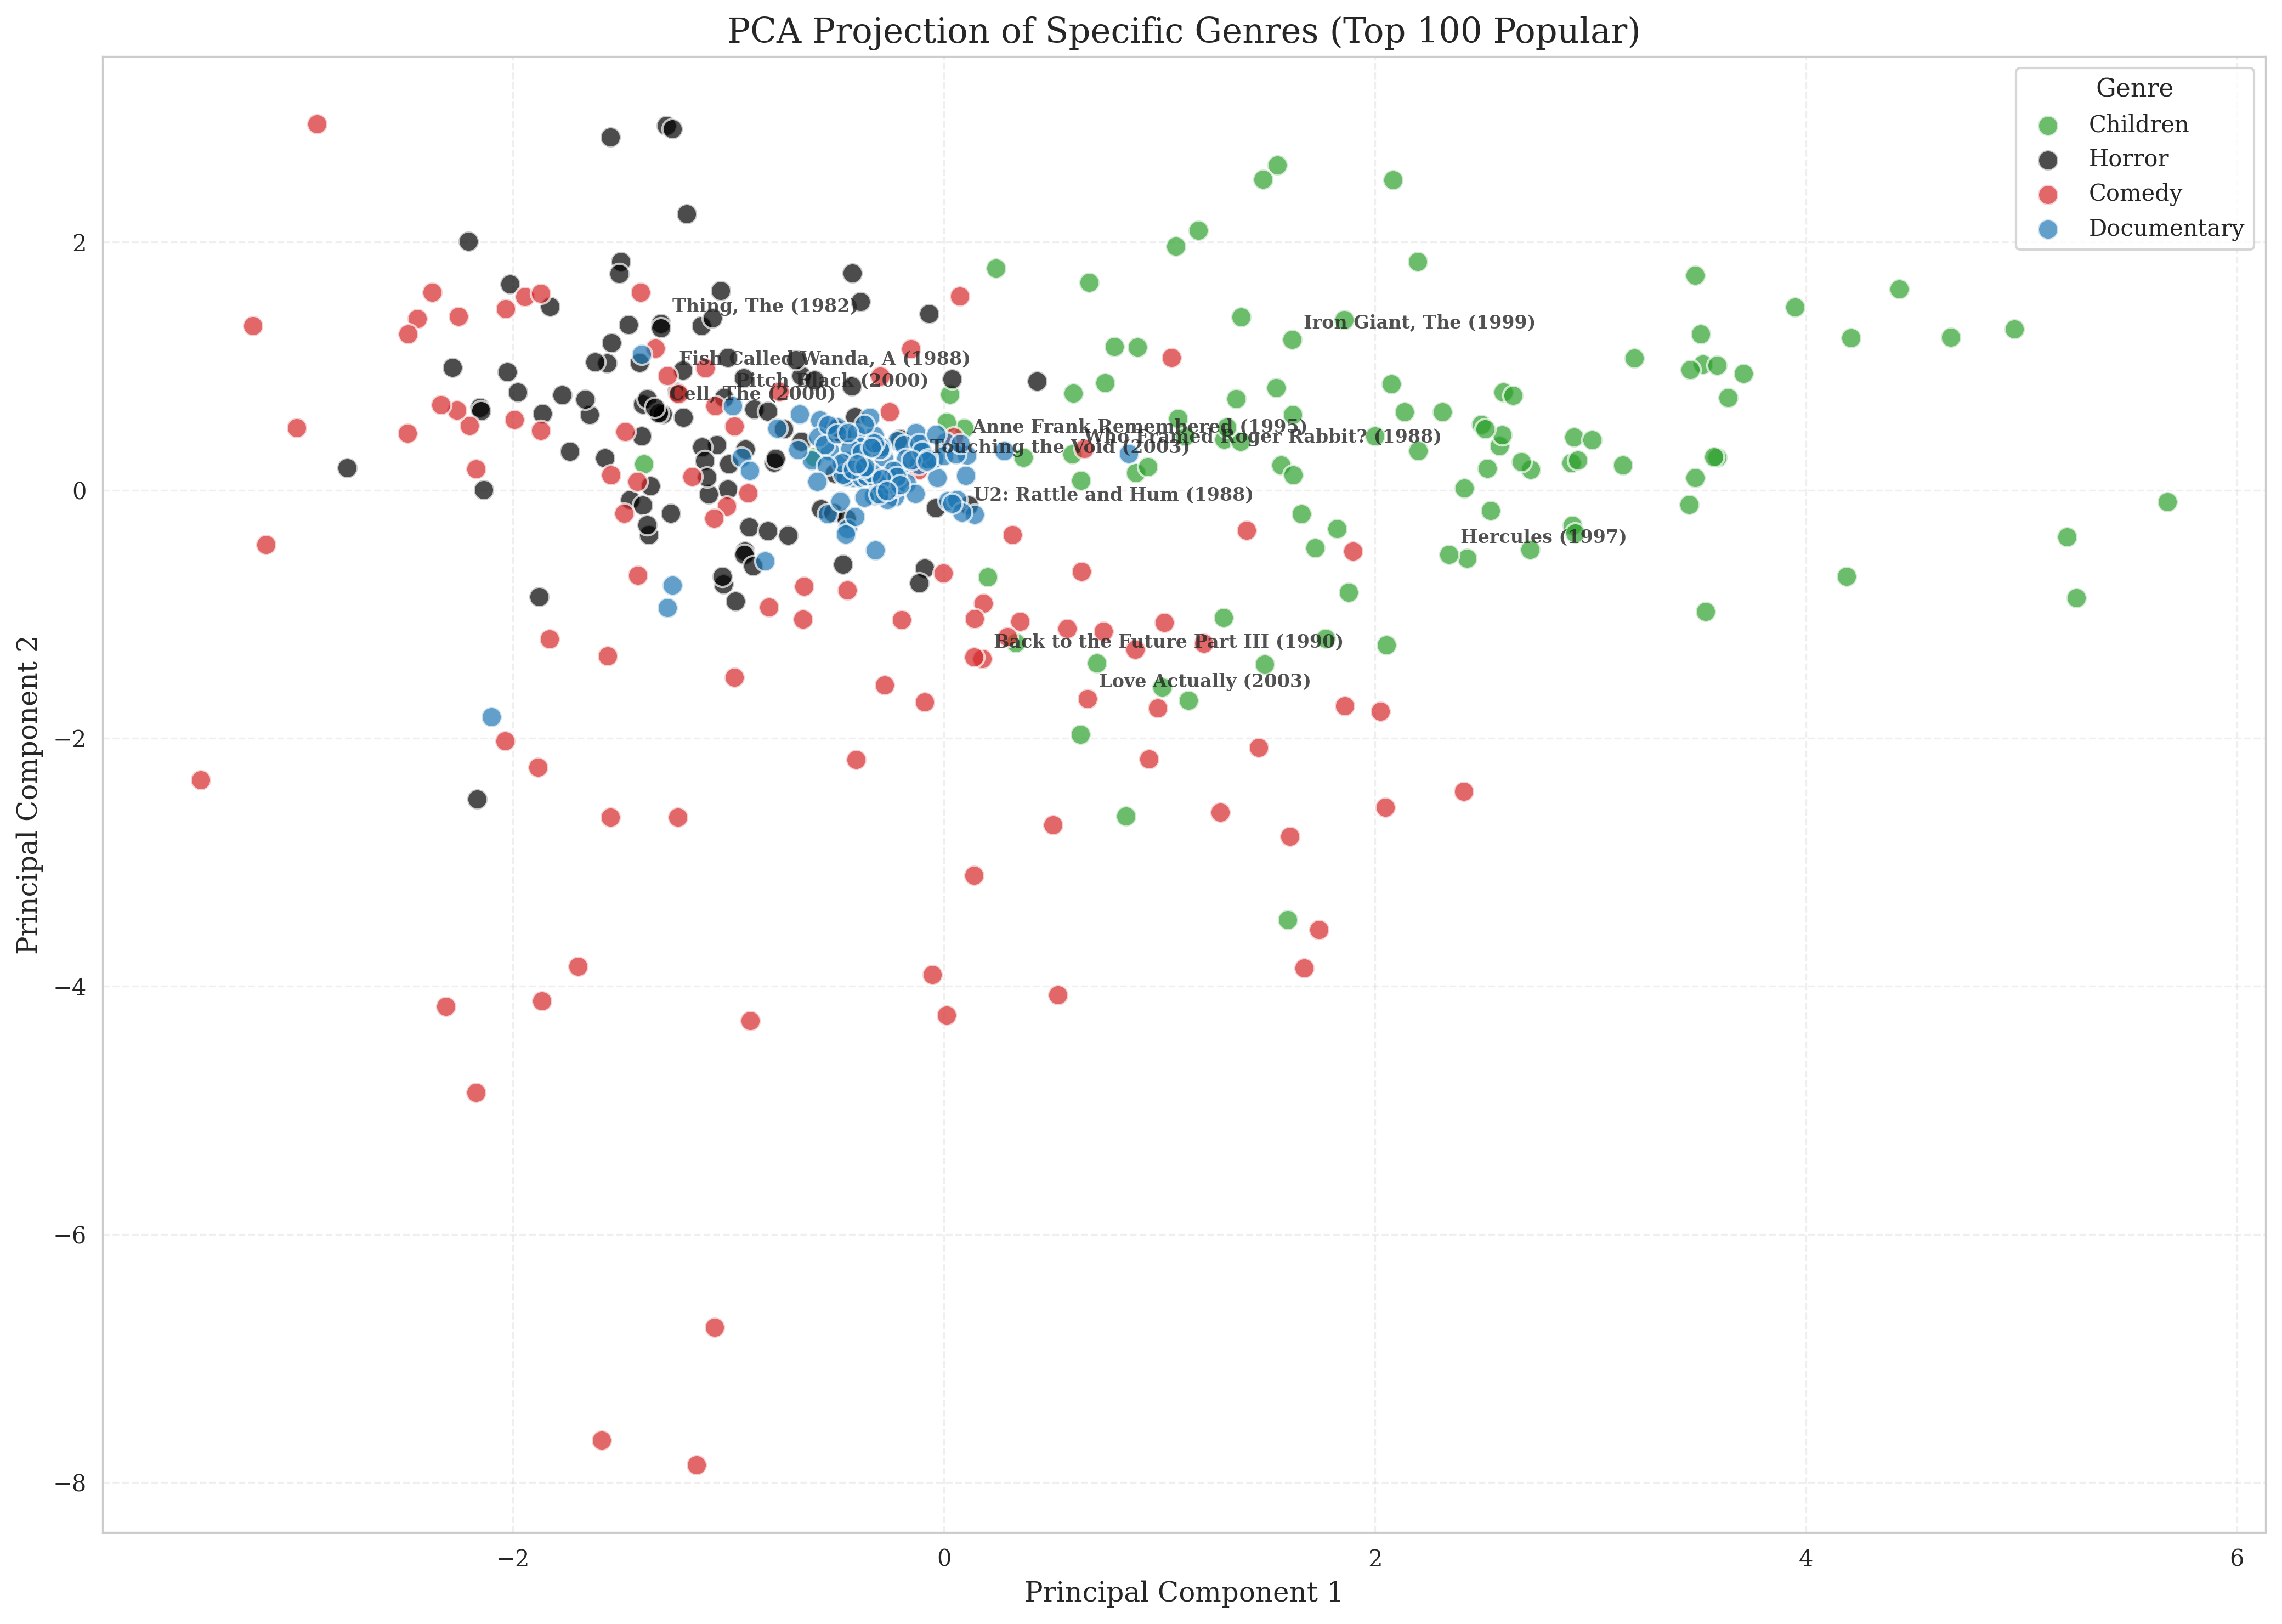

In [79]:
# 1. NUMBA KERNELS

@njit(parallel=True)
def get_movie_counts_numba(movie_ptr):
    """Fast rating counts"""
    n_movies = len(movie_ptr) - 1
    counts = np.zeros(n_movies, dtype=np.int32)
    for m in prange(n_movies):
        counts[m] = movie_ptr[m+1] - movie_ptr[m]
    return counts

@njit(parallel=True)
def _numba_standard_scaler(data):
    """Optimized StandardScaler (Z-score normalization)"""
    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in prange(n_features):
        col_sum = 0.0
        col_sq_sum = 0.0
        for i in range(n_samples):
            val = data[i, j]
            col_sum += val
            col_sq_sum += val**2

        mean = col_sum / n_samples
        var = (col_sq_sum / n_samples) - (mean * mean)
        std = np.sqrt(var) if var > 0 else 1.0

        for i in range(n_samples):
            scaled[i, j] = (data[i, j] - mean) / std

    return scaled

@njit
def _numba_pca_2d(data):
    """Optimized PCA for 2 components"""
    n_samples = data.shape[0]
    # Sample Covariance Matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition (returns eigenvalues in ascending order)
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort descending (Top 2)
    idx = np.argsort(eig_vals)[::-1]
    components = eig_vecs[:, idx[:2]]

    # Project
    return data @ components

# 2. VISUALIZATION FUNCTION
def visualize_specific_genres_pca(ratings_matrix, movie_embeddings, df_movies,
                                  target_genres=['Children', 'Horror', 'Sci-Fi', 'Documentary'],
                                  samples_per_genre=100):

    print(f"1. Sorting movies by popularity...")
    counts = get_movie_counts_numba(ratings_matrix.movie_ptr)
    sorted_indices = np.argsort(counts)[::-1]

    print(f"2. Collecting top {samples_per_genre} movies for: {target_genres}...")

    collected_data = {genre: [] for genre in target_genres}
    seen_movies = set()

    # Filter Logic
    for idx in sorted_indices:
        if all(len(collected_data[g]) >= samples_per_genre for g in target_genres):
            break

        movie_id = ratings_matrix.idx_to_movieid[idx]
        if movie_id in seen_movies: continue

        try:
            row = df_movies[df_movies['movieId'] == movie_id].values[0]
            title = row[1]
            genre_str = row[2]

            for target in target_genres:
                if target in genre_str:
                    if len(collected_data[target]) < samples_per_genre:
                        collected_data[target].append({
                            'embedding': movie_embeddings[:, idx], # Shape (k,)
                            'title': title,
                            'genre_label': target
                        })
                        seen_movies.add(movie_id)
                        break
        except IndexError:
            continue

    # Prepare Data for PCA
    final_embeddings = []
    final_labels = []
    final_titles = []

    for genre in target_genres:
        print(f"   Found {len(collected_data[genre])} movies for '{genre}'")
        for item in collected_data[genre]:
            final_embeddings.append(item['embedding'])
            final_labels.append(item['genre_label'])
            final_titles.append(item['title'])

    # Convert to Array (N_samples, k)
    X = np.array(final_embeddings, dtype=np.float64)

    print(f"3. Running Numba PCA on shape {X.shape}...")

    X_std = _numba_standard_scaler(X)
    pca_results = _numba_pca_2d(X_std)

    print("4. Generating PCA Plot...")
    plt.figure(figsize=(14, 10))

    genre_colors = {
        'Children': 'tab:green',
        'Horror': 'black',
        'Comedy': 'tab:red',
        'Documentary': 'tab:blue'
    }

    # Plotting Loop
    for genre in target_genres:
        indices = [i for i, x in enumerate(final_labels) if x == genre]
        if not indices: continue

        points_x = pca_results[indices, 0]
        points_y = pca_results[indices, 1]

        plt.scatter(points_x, points_y,
                    c=genre_colors.get(genre, 'gray'),
                    label=genre,
                    s=80, alpha=0.7, edgecolors='white')

        # Annotate a few random titles
        import random
        if len(indices) > 0:
            subset_indices = random.sample(indices, min(3, len(indices)))
            for i in subset_indices:
                plt.annotate(final_titles[i],
                             (pca_results[i, 0], pca_results[i, 1]),
                             fontsize=8, weight='bold', alpha=0.8,
                             xytext=(5, 5), textcoords='offset points')

    plt.title(f"PCA Projection of Specific Genres (Top {samples_per_genre} Popular)", fontsize=15)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Genre")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('pca_genre.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# EXECUTION
visualize_specific_genres_pca(
    ratings_matrix,
    movie_embeddings,
    df2,
    target_genres=['Children', 'Horror', 'Comedy', 'Documentary'],
    samples_per_genre=100
)